# DESI PV Y3 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-cluster joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **May 20, 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

Changes I am adding:
- Adding $V_{max}$ weighting
- Implementing coordinate corrections
- Adjusting cluster membership

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Jura Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* (eventually Visual inspection)

In [3]:
# sgapath = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3'
sgapath = ''
# sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot_VI.fits')

sgatab = Table.read(sgafits)
sgatab

<Table length=35679>
 SGA_ID    SGA_GALAXY    ...      V_0p4R26         V_0p4R26_err   
 int64      bytes16      ...      float64            float64      
------- ---------------- ... ------------------ ------------------
     20      SGA-2020 20 ... 147.82237894320167  4.528884919879512
     32      SGA-2020 32 ...  264.4537334962159 12.703124777339772
     38      SGA-2020 38 ...  131.7204980109027 2.7000243414015537
     53      SGA-2020 53 ...  269.3971746696992  5.699540655454983
     55      SGA-2020 55 ...  81.96380902973591 3.1957190840943728
     63      SGA-2020 63 ...   91.3777286515229 2.1564839156492313
     74      SGA-2020 74 ...  95.96961734753083 1.9820116977757078
     76      SGA-2020 76 ... 136.69374676554472  7.619682654847482
    117     SGA-2020 117 ... 199.31795125815435  8.058354246840409
    146     SGA-2020 146 ... 174.84306068818927 0.6186216089875395
    ...              ... ...                ...                ...
5002979 SGA-2020 5002979 ... 146.70900655385103 12.531496826591164
5002994 SGA-2020 5002994 ...  72.41767549081787  4.340810310325538
5003004 SGA-2020 5003004 ... 60.448478426807355 3.3247534088906847
5003016 SGA-2020 5003016 ... 107.28956953697448 1.9167795108204821
5003025 SGA-2020 5003025 ...  46.88669883616818  3.699465058066751
5003026 SGA-2020 5003026 ... 252.77498469165545  7.351844250373584
5003042 SGA-2020 5003042 ... 137.60810216730812 15.881552401427436
5003044 SGA-2020 5003044 ...  195.8725337040959  17.62449436158271
5003075 SGA-2020 5003075 ... 114.98219785520891   4.49883027792885
5003690 SGA-2020 5003690 ...  159.1082154250024 0.8240692283110285

## Compute Maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$
 arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA. Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)


dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

# Read in Morphological classifications

In [5]:
ai_morphtab=Table.read('/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/SGAY3TFMorphologies.csv')
ai_morphtab

<Table length=35792>
  SGA_ID  Predicted_Type_spiral ... Predicted_Type_lenticular Predicted_Type
 float64           str6         ...           str10               str10     
--------- --------------------- ... ------------------------- --------------
 218203.0                 Other ...                     Other      Irregular
 218205.0                 Other ...                     Other      Irregular
 218239.0                 Other ...                     Other      Irregular
 218275.0                 Other ...                     Other      Irregular
 218304.0                Spiral ...                     Other         Spiral
 218367.0                 Other ...                     Other      Irregular
 218376.0                Spiral ...                     Other         Spiral
 218201.0                 Other ...                     Other      Irregular
 218385.0                Spiral ...                     Other         Spiral
 217784.0                 Other ...                     Other      Irregular
      ...                   ... ...                       ...            ...
 994412.0                 Other ...                     Other      Undecided
 994319.0                Spiral ...                     Other         Spiral
 997867.0                 Other ...                     Other      Undecided
    146.0                Spiral ...                     Other         Spiral
 607946.0                Spiral ...                     Other         Spiral
1078924.0                Spiral ...                     Other         Spiral
  10093.0                Spiral ...                     Other         Spiral
 668149.0                Spiral ...                     Other         Spiral
1266591.0                Spiral ...                     Other         Spiral
1265003.0                Spiral ...                     Other         Spiral

# Combine ML morphtypes with SGA catalog

In [6]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

In [7]:
sgatab

<Table length=35679>
  SGA_ID     SGA_GALAXY    ...    MAX_VOL_FRAC    MORPHTYPE_AI
                           ...                                
 float64      bytes16      ...      float64          str10    
--------- ---------------- ... ------------------ ------------
     20.0      SGA-2020 20 ...  6.272968831604057    Irregular
     32.0      SGA-2020 32 ...  35.20151617603084       Spiral
     38.0      SGA-2020 38 ...  4.653415963388956       Spiral
     53.0      SGA-2020 53 ...  6.784206492201509       Spiral
     55.0      SGA-2020 55 ... 1.1549890528326399       Spiral
     63.0      SGA-2020 63 ... 2.8628673384125665       Spiral
     74.0      SGA-2020 74 ...  5.024141056225913       Spiral
     76.0      SGA-2020 76 ... 1.6344245453375543       Spiral
    117.0     SGA-2020 117 ... 16.329382765500124       Spiral
      ...              ... ...                ...          ...
5002979.0 SGA-2020 5002979 ...  7.799784457618529       Spiral
5002994.0 SGA-2020 5002994 ... 2.1101000974027646       Spiral
5003004.0 SGA-2020 5003004 ...  2.032980174521973       Spiral
5003016.0 SGA-2020 5003016 ... 10.402965637256607    Irregular
5003025.0 SGA-2020 5003025 ... 0.9786391353112524    Undecided
5003026.0 SGA-2020 5003026 ...  98.35498437505196       Spiral
5003042.0 SGA-2020 5003042 ... 10.332392043858361       Spiral
5003044.0 SGA-2020 5003044 ... 30.028030909465297       Spiral
5003075.0 SGA-2020 5003075 ...  3.847523967122841       Spiral
5003690.0 SGA-2020 5003690 ... 1.7257022224133989       Spiral

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [8]:
############################## Version to run after the morphological classifier is complete


#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue
        
#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_morph, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph
is_good_sga_ML = is_good_incl & is_good_morph_ML

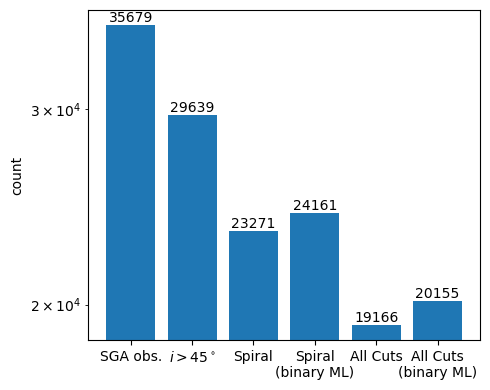

In [9]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'All Cuts' : np.sum(is_good_sga), 
    'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count', yscale='log', );

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150);

## Add in Photometric Corrections

These are the same that are done in "TF_jura_internal-dustCorr.ipynb".

In [10]:
### Survey Offsets
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

In [11]:
#### Milky Way Dust Corrections
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map) 
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0 #flip NaN to 0

/global/homes/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [12]:
#### K-Corrections
zg0 = sgatab['Z_DESI'] >= 0 #ignore the few random gals with negative redshift

kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

In [13]:
###### Internal dust correction
temp_infile = open('jura_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [14]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [15]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

In [16]:
###### Apply all these corrections
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA Jura observations that have passed all quality cuts.

In [17]:
zeroptpath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/tf_0pt/'
zeroptab = Table.read(os.path.join(zeroptpath, 'SGA_SNmatches+secondary.fits'))

In [18]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.isin(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
# zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab['SGA_ID', 'GALAXY', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_SOURCE'].show_in_notebook()

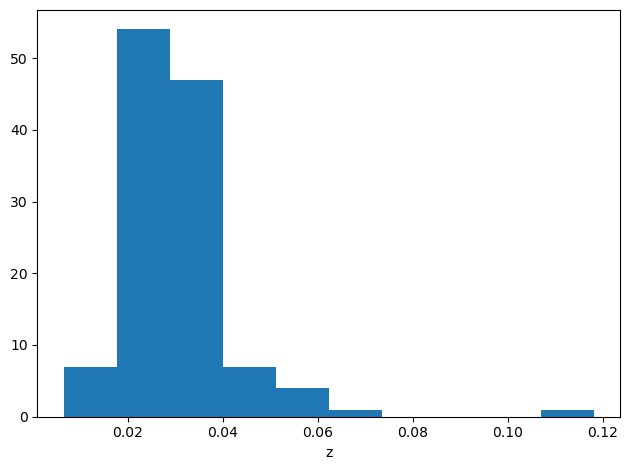

In [19]:
plt.figure(tight_layout=True)
plt.hist(zeroptab['Z_DESI'])
plt.xlabel('z');

In [20]:
###### Only keep galaxies with a primary SN match
zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [21]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=17>
        1998dm
        1999ac
        2000dg
        2001ep
        2003he
        2005hc
        2007fb
        2010ao
        2010dt
 2013gy+2009kk
          2561
   ASASSN-16hh
       PS15aii
       PS15bsq
       PS15cms
       PS16axi
        PS16fa,
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

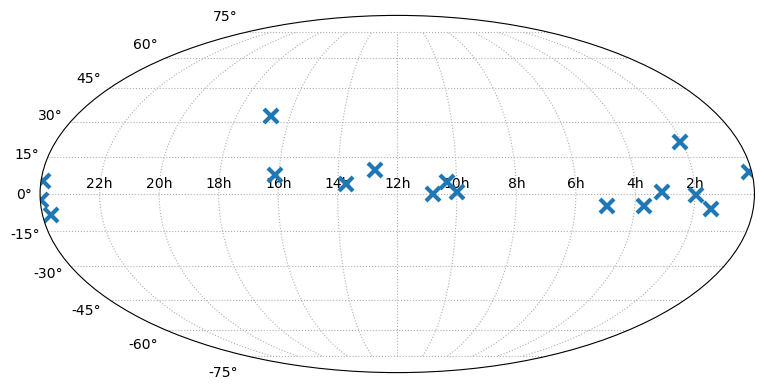

In [22]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

## Compute the absolute magnitude of these zero-pt calibrators based on their distance

In [23]:
#- Clean up the distance modulus
# use_primary = zeroptab['MU_SECONDARY'] < 0
# mu = zeroptab['MU_SECONDARY']
# mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [24]:
# # # Save this table
# zeroptab.write('SGA-2020_jura_Vrot_VI_0pt_PRIMARY_calib_z0p1.fits', overwrite=True)

In [25]:
# ### Once we have already done this, we can just read in the table instead
# zeroptab = Table.read('SGA-2020_jura_Vrot_VI_0pt_calib_z0p1.fits')


# use_primary = zeroptab['MU_SECONDARY'] < 0
# mu = zeroptab['MU_SECONDARY']
# mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]

In [26]:
##### If we want year 1 calibrators:
# zeroptab_Y1 = Table.read('/global/homes/s/sgmoore1/DESI_SGA/TF/Y1/SGA-2020_iron_Vrot_VI_0pt_calib_z0p1.fits')
# zeroptab_Y3 = Table.read('SGA-2020_jura_Vrot_VI_0ptPRIMARY_calib_z0p1.fits')

# mask = np.isin(zeroptab_Y3['SGA_ID'], zeroptab_Y1['SGA_ID'])

# zeroptab = zeroptab[mask]

# use_primary = zeroptab['MU_SECONDARY'] < 0
# mu = zeroptab['MU_SECONDARY']
# mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]

In [25]:
zeroptab[:5]

<Table length=5>
 SGA_ID     SGA_GALAXY   ...    R_ABSMAG_SB26     R_ABSMAG_SB26_err 
                         ...                                        
float64      bytes16     ...       float64             float64      
-------- --------------- ... ------------------- -------------------
 33836.0  SGA-2020 33836 ... -21.780022807908054 0.28346788091873143
 56684.0  SGA-2020 56684 ...  -21.82291315299347 0.27628709609461866
109750.0 SGA-2020 109750 ...  -22.06360939331502 0.20588121367047227
179731.0 SGA-2020 179731 ... -22.055402617251872  0.2780885512623444
292881.0 SGA-2020 292881 ... -22.447687988394502 0.18102407424428818

# Access Cluster Catalog

These clusters come from the group catalog used by Kourkchi et al. in [*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*](https://iopscience.iop.org/article/10.3847/1538-4357/ab901c), ApJ 896:3, 2020.

Cluster membership is defined as
1. $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_p$, OR
1. $1.5R_{2t} \leq R_p < 3R_{2t}$ AND $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [26]:
clusters_T = Table.read('../Tully15-Table3.fits')
clusters_T[:5]

<Table length=5>
f_Nest  Nest   Nmb    PGC1   SGLON   ...  sigV    R2t    sigP     Mlum      CF  
                              deg    ... km / s   Mpc   km / s    Msun          
int16  int32  int16  int32  float64  ... int16  float64 int16   float64  float64
------ ------ ----- ------- -------- ... ------ ------- ------ --------- -------
     1 100001   136   44715  89.6226 ...    886   2.129   1045 1.710e+15    1.65
     1 100002   197   41220 103.0008 ...    670   1.440    707 5.290e+14    1.00
     1 100003   113   43296 156.2336 ...    822   1.520    746 6.230e+14    1.12
     1 100004    81   58265  71.5103 ...    740   2.153   1057 1.770e+15    2.26
     1 100005    61   36487  92.0255 ...    707   1.560    766 6.730e+14    1.58

In [27]:
# Convert Tully's central cluster velocities to heliocentric frame (to match the DESI redshift frame)
cls_coords = SkyCoord(clusters_T['SGLON'], clusters_T['SGLAT'], unit='deg', frame='supergalactic').icrs
z_hel = convert_z_frame(clusters_T['<Vcmba>']/c.c.to('km/s'), cls_coords.ra.deg, cls_coords.dec.deg, corrtype='-full')
clusters_T['HRV'] = z_hel*c_kms
clusters_T[:5]

<Table length=5>
f_Nest  Nest   Nmb    PGC1  ...  sigP     Mlum      CF          HRV        
                            ... km / s    Msun                             
int16  int32  int16  int32  ... int16   float64  float64      float64      
------ ------ ----- ------- ... ------ --------- ------- ------------------
     1 100001   136   44715 ...   1045 1.710e+15    1.65  7056.410096941048
     1 100002   197   41220 ...    707 5.290e+14    1.00 1161.7922735623201
     1 100003   113   43296 ...    746 6.230e+14    1.12 3587.4600297854763
     1 100004    81   58265 ...   1057 1.770e+15    2.26  9399.655364870352
     1 100005    61   36487 ...    766 6.730e+14    1.58  6653.443936152573

In [28]:
clusters_K = Table.read('../Kourkchi17-Table2.fits.gz')
clusters_K[:5]

<Table length=5>
  PGC1   PGC1+    Nm    GLON     GLAT   ...   R2t      Rg    logMK   logMd 
                        deg      deg    ...   Mpc     Mpc    [Msun]  [Msun]
 int32   int32  int16 float64  float64  ... float64 float64 float64 float64
------- ------- ----- -------- -------- ... ------- ------- ------- -------
  43296   43296   191 302.2241  21.6465 ...   1.612   0.893  14.624  14.717
  46618   43296    30 307.8738  19.2865 ...   0.950   0.745  13.936  13.808
  45174   43296    34 306.0424  32.5707 ...   0.833   0.693  13.764  13.756
  40498   43296    24 297.5648  23.0823 ...   0.801   0.607  13.713  13.207
  43557   43296    22 302.9333  36.4075 ...   0.724   0.428  13.582  13.017

In [29]:
# Rename columns to match Tully's catalog
clusters_K['Nm'].name = 'Nmb'
clusters_K['sigmaL'].name = 'sigP'
clusters_K['sigmaV'].name = 'sigV'

# Convert from distance to distance modulus
clusters_K['DM'] = 5*np.log10(clusters_K['Dist'].value) + 25

# Define NestID
clusters_K['Nest'] = np.char.add('3', clusters_K['PGC1'].astype('str')).astype('int')

/tmp/ipykernel_1180892/1224197170.py:7: RuntimeWarning: divide by zero encountered in log10
  clusters_K['DM'] = 5*np.log10(clusters_K['Dist'].value) + 25


## Combine these two cluster catalogs

In [30]:
# Determine which clusters in Kourkchi's table are already in Tully's
K_keep = np.ones(len(clusters_T), dtype=bool)

for i in range(len(clusters_K)):
    K_keep = K_keep & (clusters_T['PGC1'] != clusters_K['PGC1'][i])

clusters_all = vstack([clusters_T[K_keep], clusters_K])

clusters = clusters_all['Nest', 'Nmb', 'PGC1', 'SGLON', 'SGLAT', 'DM', 'sigV', 'sigP', 'R2t', 'HRV'][clusters_all['Nmb'] >= 5]

len(clusters)

1321

## Remove overlapping clusters
These were found using Problematic_galaxy_clustering.ipynb

In [31]:
overlaps = np.loadtxt('Tully_overlaps.txt', dtype=int)
clusters = clusters[~np.isin(clusters['Nest'], overlaps)]
len(clusters)

1308

# Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Tully (2015).

Loop through the data and keep only clusters where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [32]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA'], sgatab_sel['DEC'], unit='deg')
z_sga_desi = sgatab_sel['Z_DESI']

In [33]:
sga_clusters = {}
m_dwarf_clusters = {}
n_cluster_min = 15

#- Convert distance moduli to velocities [in km/s]
velos = 100 * 10**(0.2*(clusters['DM'] - 25)) / (1 + clusters['HRV']/c_kms)
# Tully used H0 = 100 km/s/Mpc, which is why we are using 100 here and not H0

# for cluster in tqdm(clusters[['Nest', 'SGLON', 'SGLAT', 'R2t', 'sigP', 'DM']]):
for i in tqdm(range(len(clusters))):
    nest_id = clusters['Nest'][i]
    
    #- Sky coordinates of cluster
    cls_coord = SkyCoord(clusters['SGLON'][i], 
                         clusters['SGLAT'][i], 
                         unit='deg', 
                         frame='supergalactic')

    #- Cluster turnaround radius, velocity dispersion, and distance modulus
    R2t = clusters['R2t'][i]
    # sigP = clusters['sigP'][i]
    sigV = clusters['sigV'][i]
    velo = velos[i]

    #- Apply cuts on angular separation
    sep = cls_coord.separation(sga_coords)
    R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
    R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian

    #- Apply cluster cuts.
    in_cluster_1 = (sep < R2t_angle_1p5) & (z_sga_desi*c_kms > velo - 3*sigV) & (z_sga_desi*c_kms < velo + 3*sigV)
    in_cluster_2 = (sep >= R2t_angle_1p5) & (sep < R2t_angle_3) & (z_sga_desi*c_kms > velo - 2*sigV) & (z_sga_desi*c_kms < velo + 2*sigV)
    in_cluster = in_cluster_1 | in_cluster_2

    if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
        if nest_id in sga_clusters:
            warnings.warn(f'Cluster ID {nest_id} already encountered.', RuntimeWarning)
        sga_clusters[nest_id] = list(sgatab_sel['SGA_ID'][in_cluster])
        m_dwarf_clusters[nest_id] = -17 + mu

/tmp/ipykernel_1180892/2928162881.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
/tmp/ipykernel_1180892/2928162881.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian
100%|██████████| 1308/1308 [00:18<00:00, 69.41it/s]


In [34]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  100001  34 galaxies
 2  100005  18 galaxies
 3  100007 131 galaxies
 4  100032  21 galaxies
 5  100042  22 galaxies
 6  100051  17 galaxies
 7  100058  20 galaxies
 8  100077  79 galaxies
 9  100094  23 galaxies
10  100098  16 galaxies
11  100125  29 galaxies
12  100132  31 galaxies
13  100135  16 galaxies
14  100168  17 galaxies
15  100220  26 galaxies
16  100221  29 galaxies
17  100282  80 galaxies
18  100292  15 galaxies
19  100375  19 galaxies
20  100386  15 galaxies
21  200011  19 galaxies
22  200043  20 galaxies
23  200284  35 galaxies
24  200382  30 galaxies
25  200384  15 galaxies
26  200386  38 galaxies
27  357649  24 galaxies
28  351104  24 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

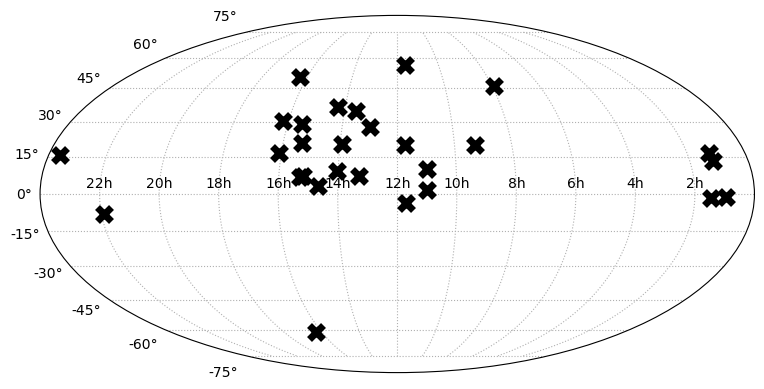

In [35]:
nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.in1d(clusters['Nest'], nest_ids)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_20241203.png', dpi=150);


In [36]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [37]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord)
    print(f'{cluster_v} +/- {cluster_sigma} km/s')

    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgacat['SGA_ID'], sga_ids)
    z_sga = sgacat['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord, radius=cluster_R2t_4)
    ax.grid()

    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    inner = SphericalCircle(cluster_coord, cluster_R2t_1p5, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner)

    outer = SphericalCircle(cluster_coord, cluster_R2t_3, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_sga, sga_coords.dec.deg, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = np.min(sga_coords.dec.deg) - 0.5
    decmax = np.max(sga_coords.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              decmin, decmax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords.ra.deg, z_sga, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = np.min(sga_coords.ra.deg) - 0.5
    ramax = np.max(sga_coords.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              ramin, ramax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.0025
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Iron Observations of Tully Group {cluster_id}')

    return fig

<SkyCoord (ICRS): (ra, dec) in deg
    (194.75582168, 27.93269246)>
7345.138681571143 +/- 1045 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (176.07089679, 20.00355552)>
6982.324040771719 +/- 766 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (210.6977648, 9.35549827)>
6637.430704019089 +/- 449 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (220.13676059, 3.3706831)>
8433.347577642775 +/- 545 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (203.55537441, 34.64649124)>
7726.805850957021 +/- 492 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.76646719, 1.62439612)>
12647.363474711521 +/- 781 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (229.29825678, 7.14058993)>
10914.403364487573 +/- 653 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (139.23844455, 20.18221015)>
8994.975815300362 +/- 510 km/s
<SkyCoord

/tmp/ipykernel_1180892/1761111452.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8), tight_layout=True)


<SkyCoord (ICRS): (ra, dec) in deg
    (17.93151711, 13.53834251)>
16904.409316432666 +/- 1285 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (328.77363049, -8.05653143)>
20044.72027365159 +/- 2055 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (354.31680741, 15.84067476)>
20044.72027365159 +/- 1643 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (18.44359042, 16.98990087)>
19860.949173573757 +/- 2303 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (244.09332814, -60.90166956)>
0.0 +/- 320 km/s


/tmp/ipykernel_1180892/1761111452.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
/tmp/ipykernel_1180892/1761111452.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
/tmp/ipykernel_1180892/1761111452.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian


<SkyCoord (ICRS): (ra, dec) in deg
    (214.31858855, 36.42507459)>
0.0 +/- 229 km/s


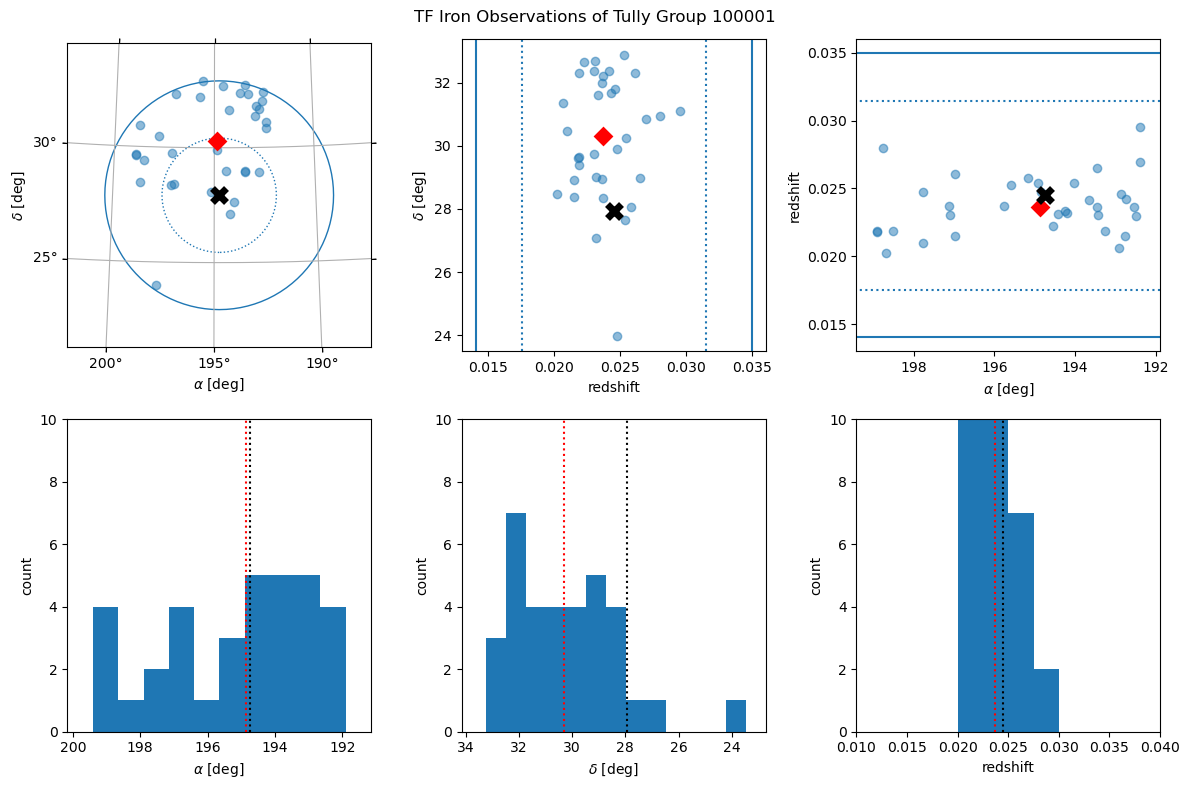

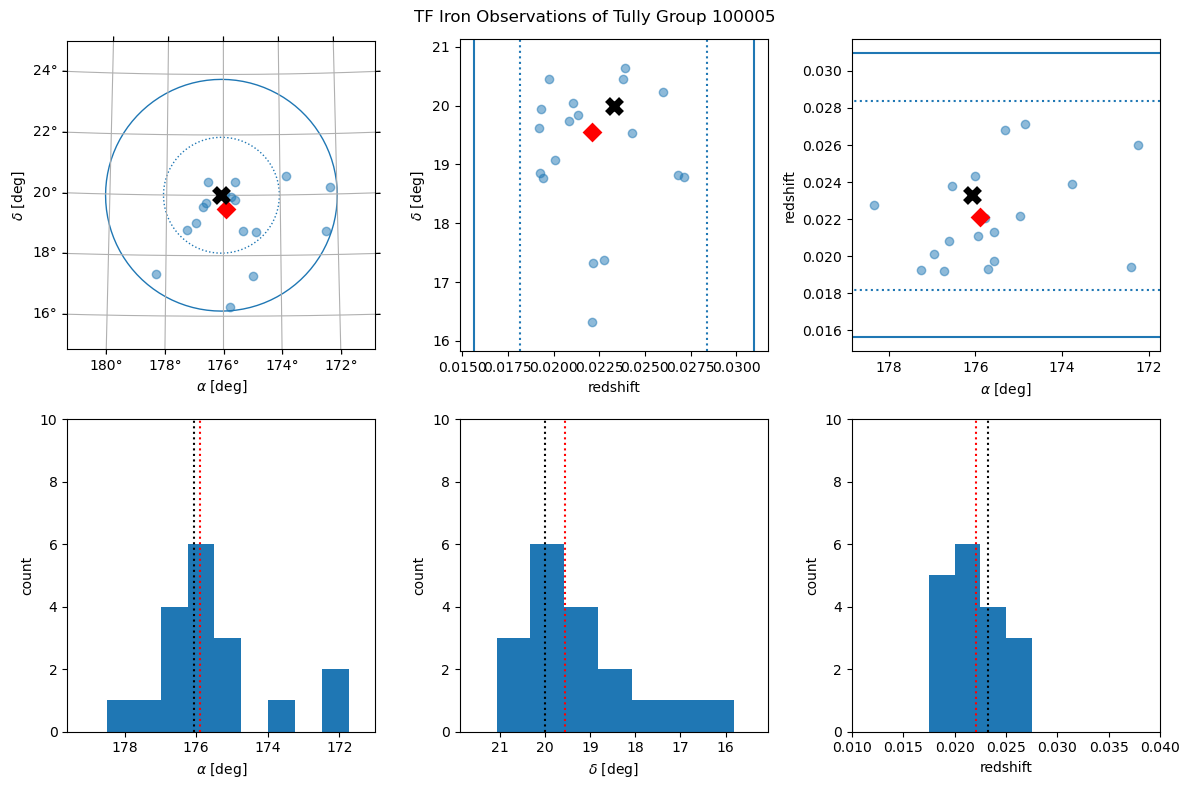

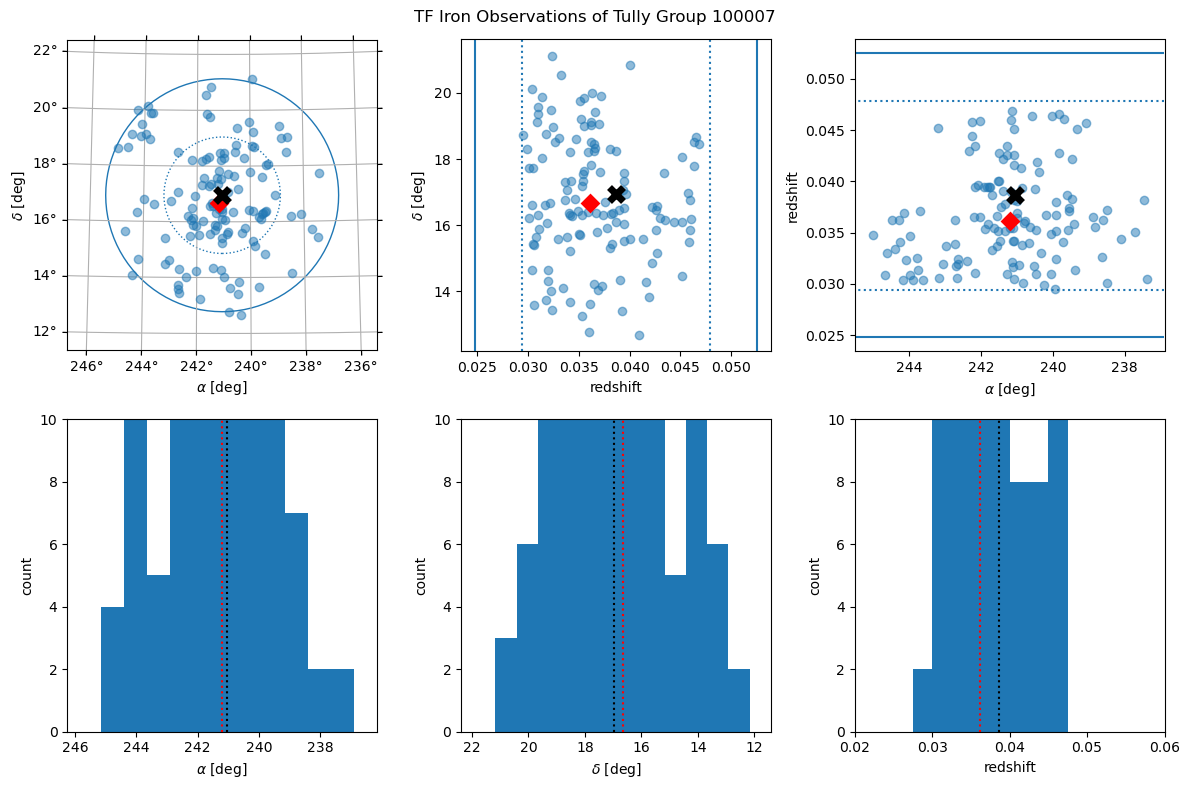

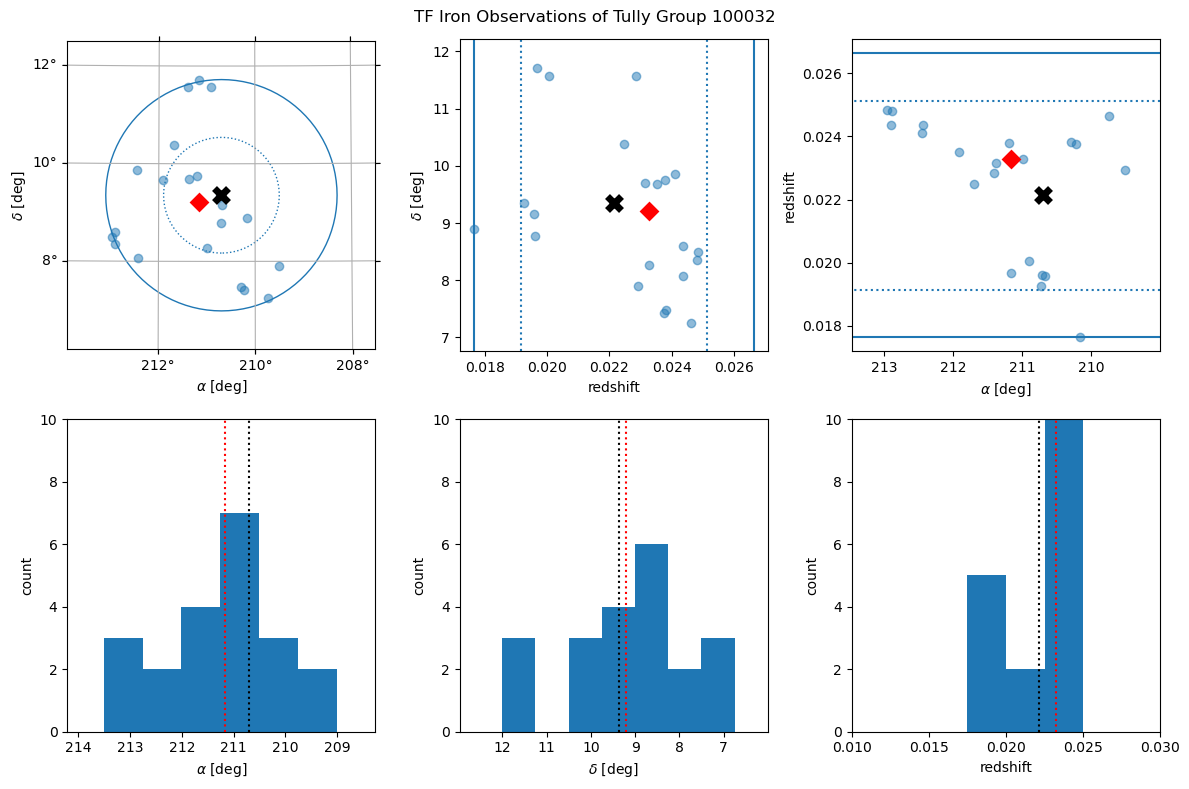

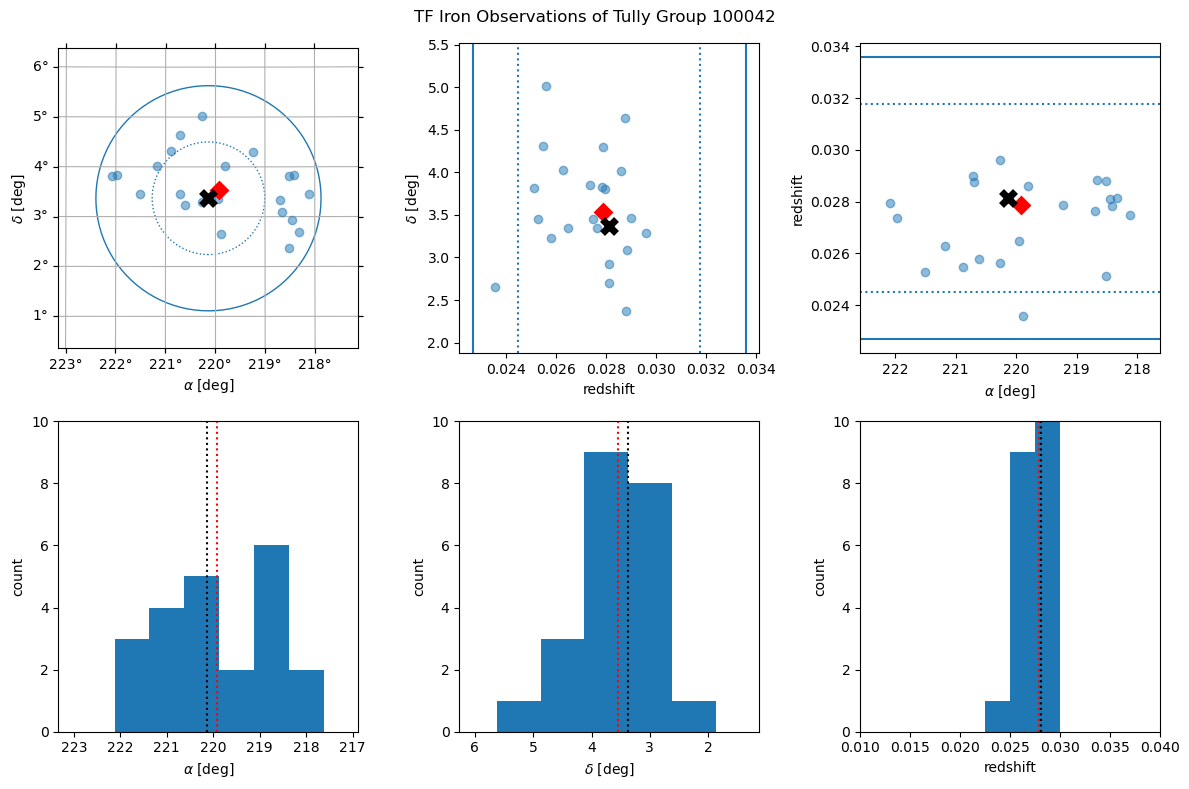

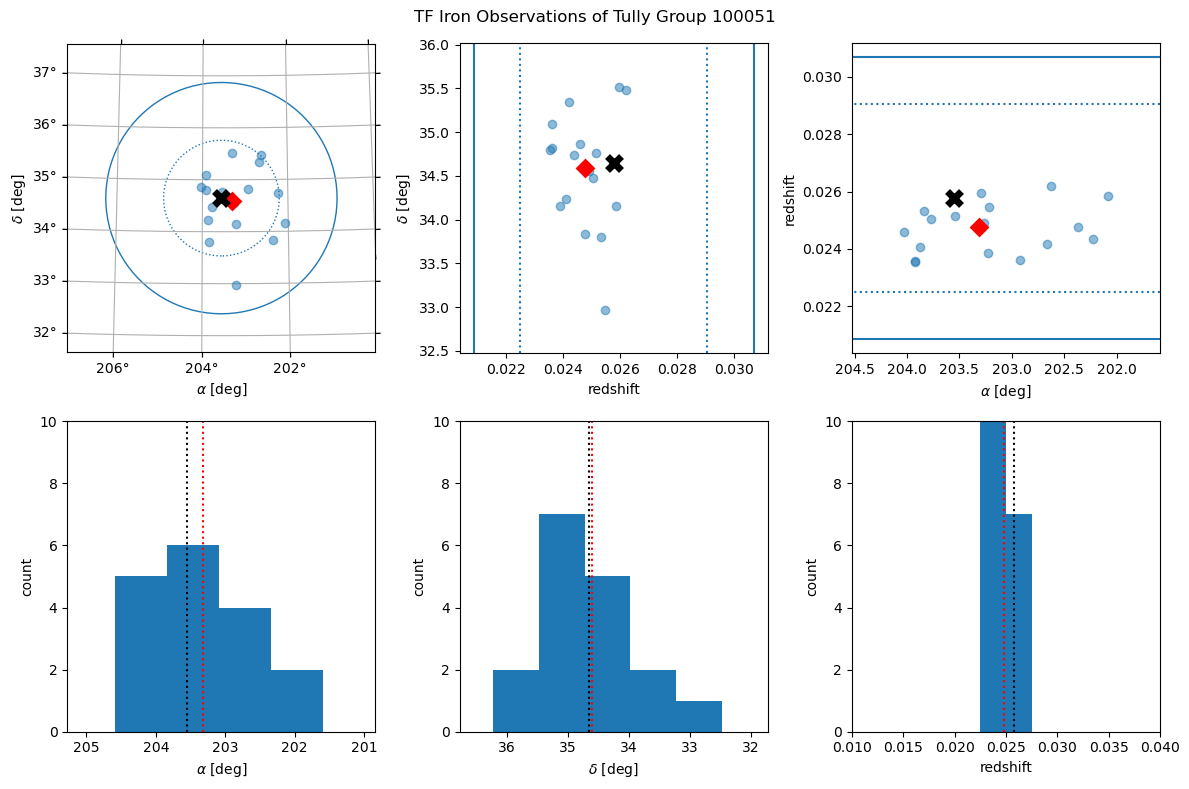

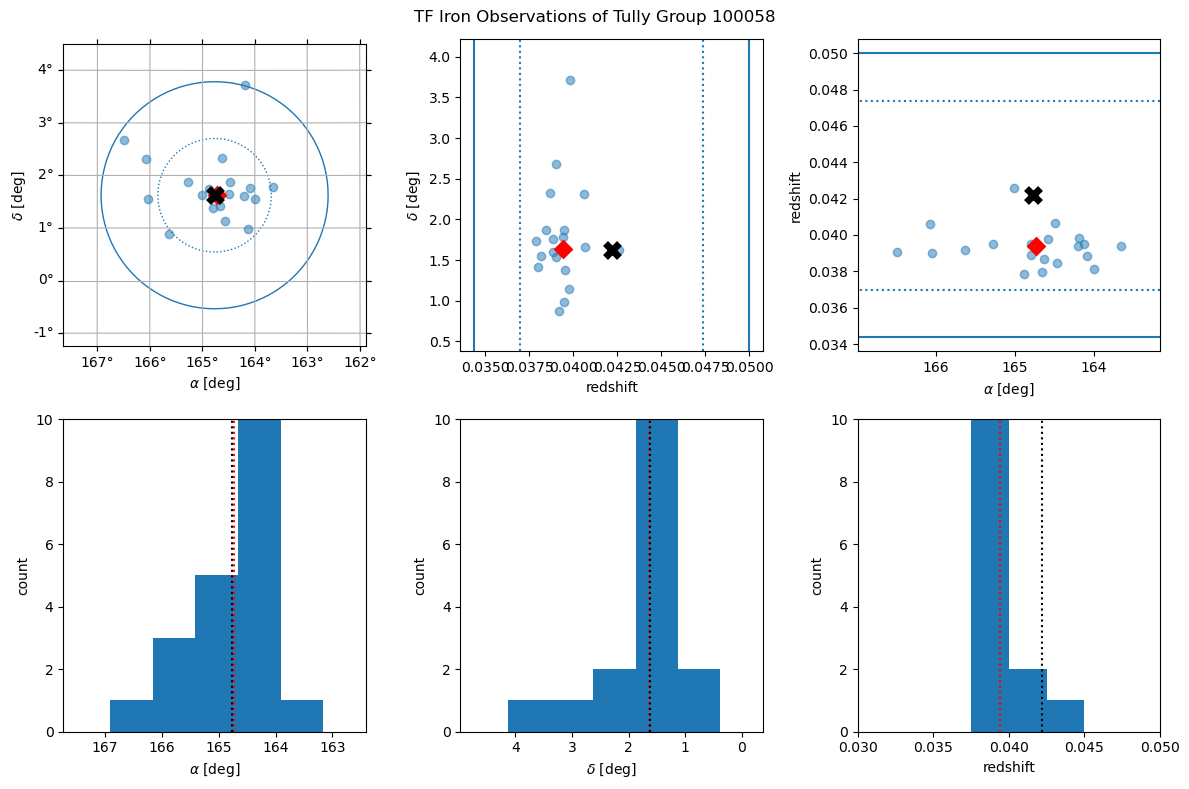

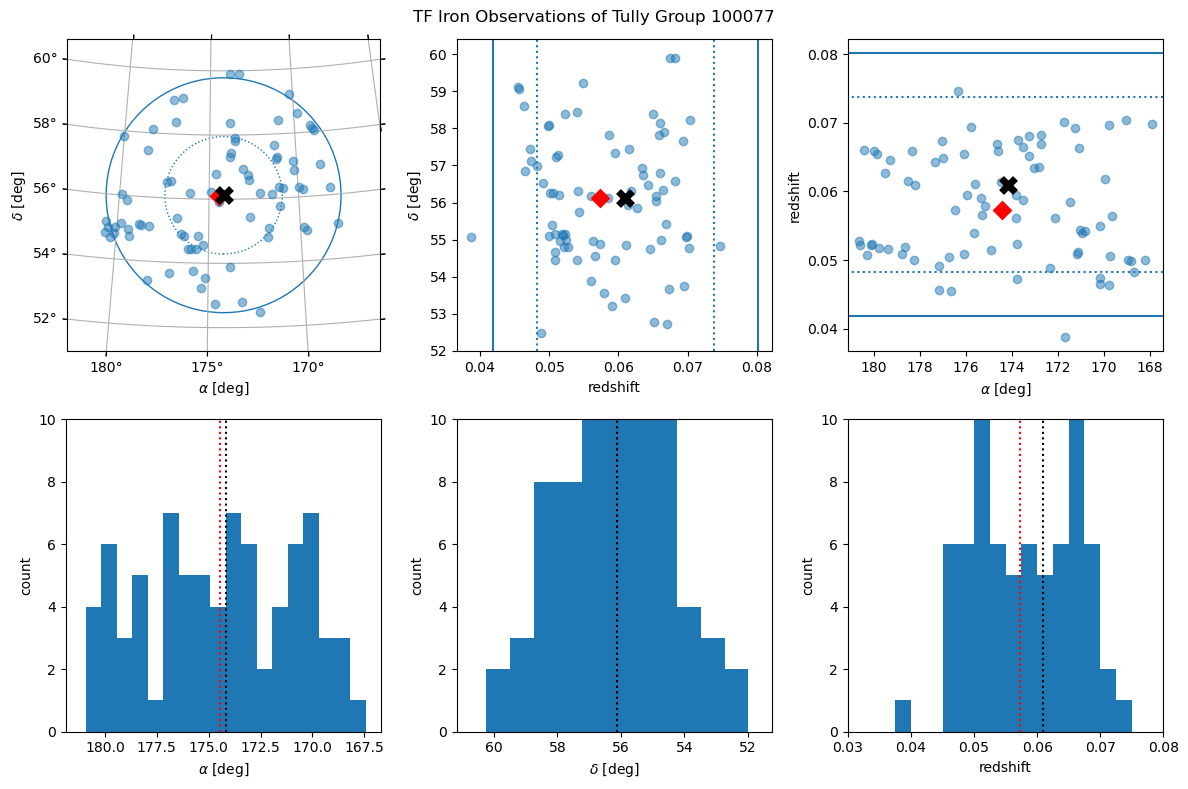

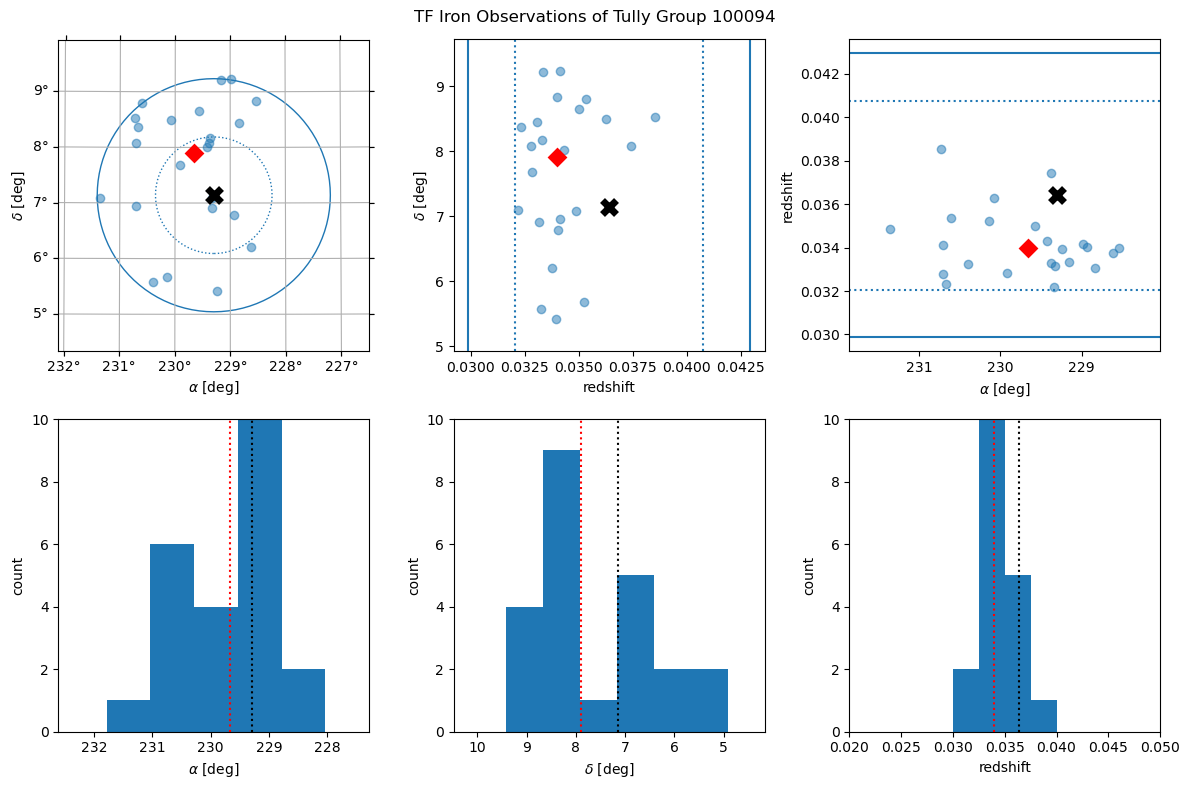

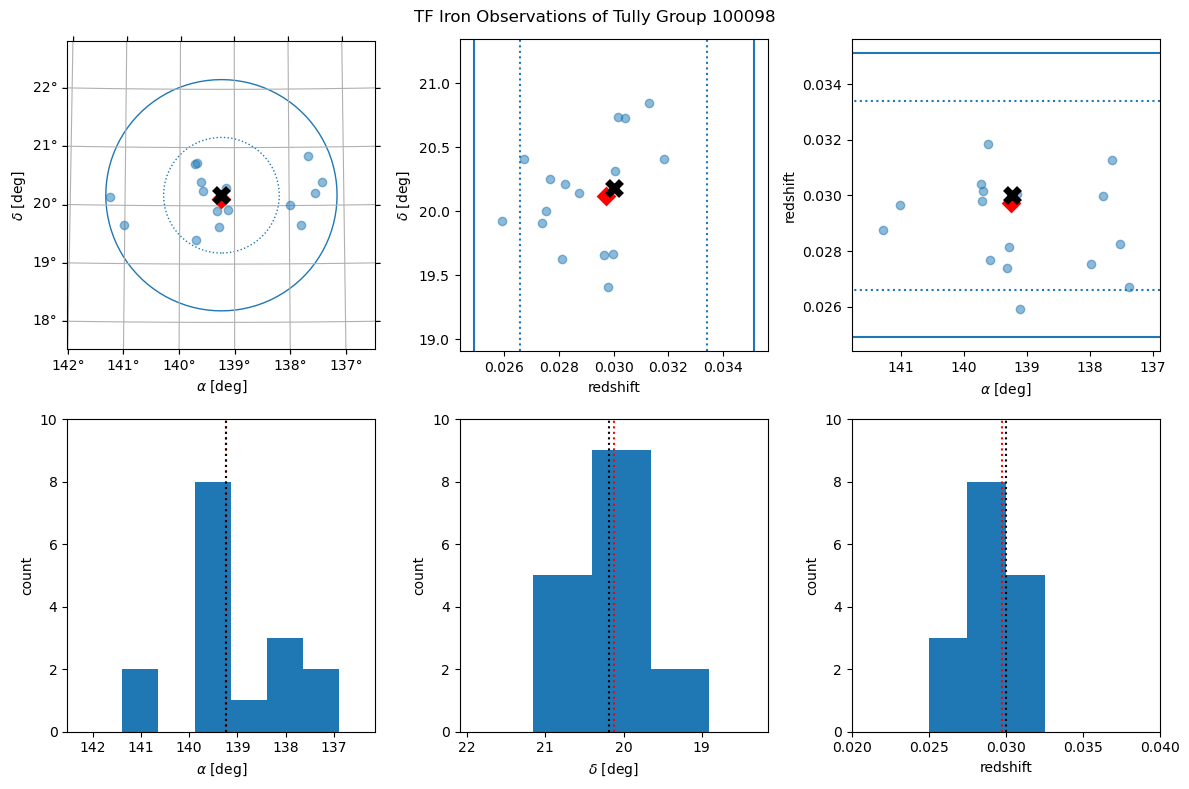

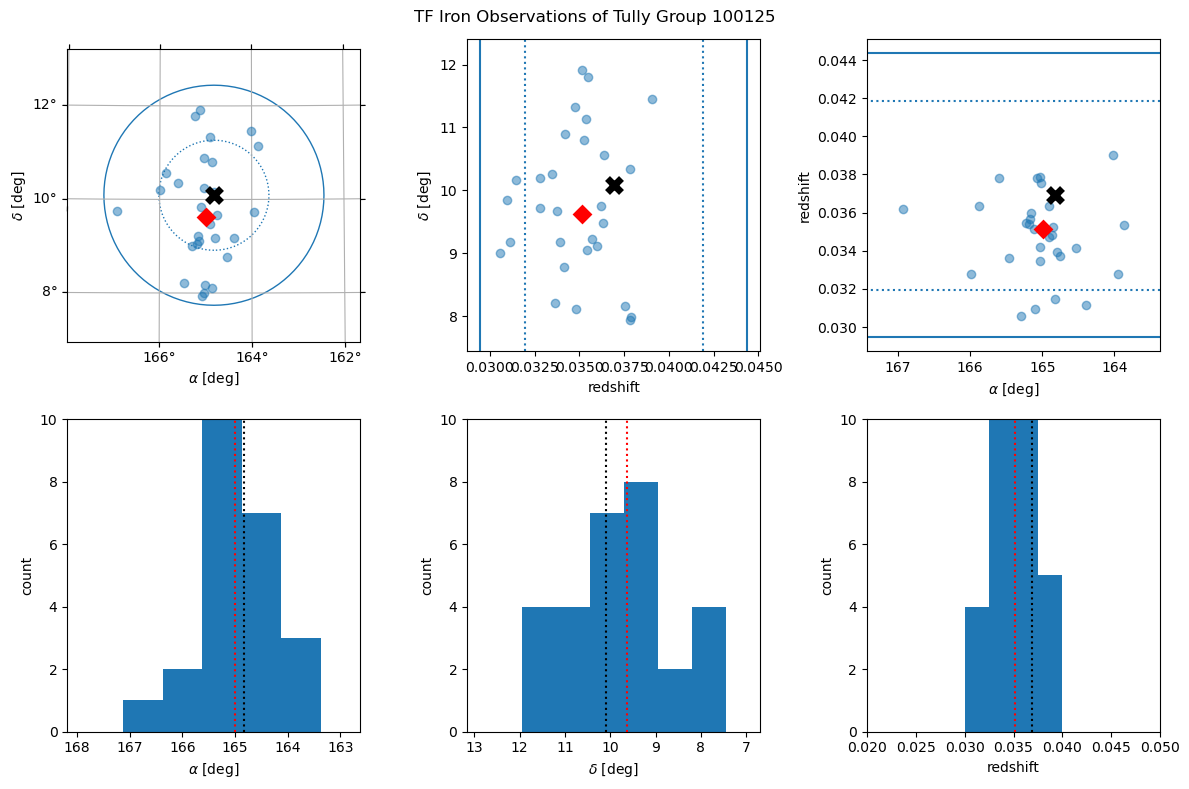

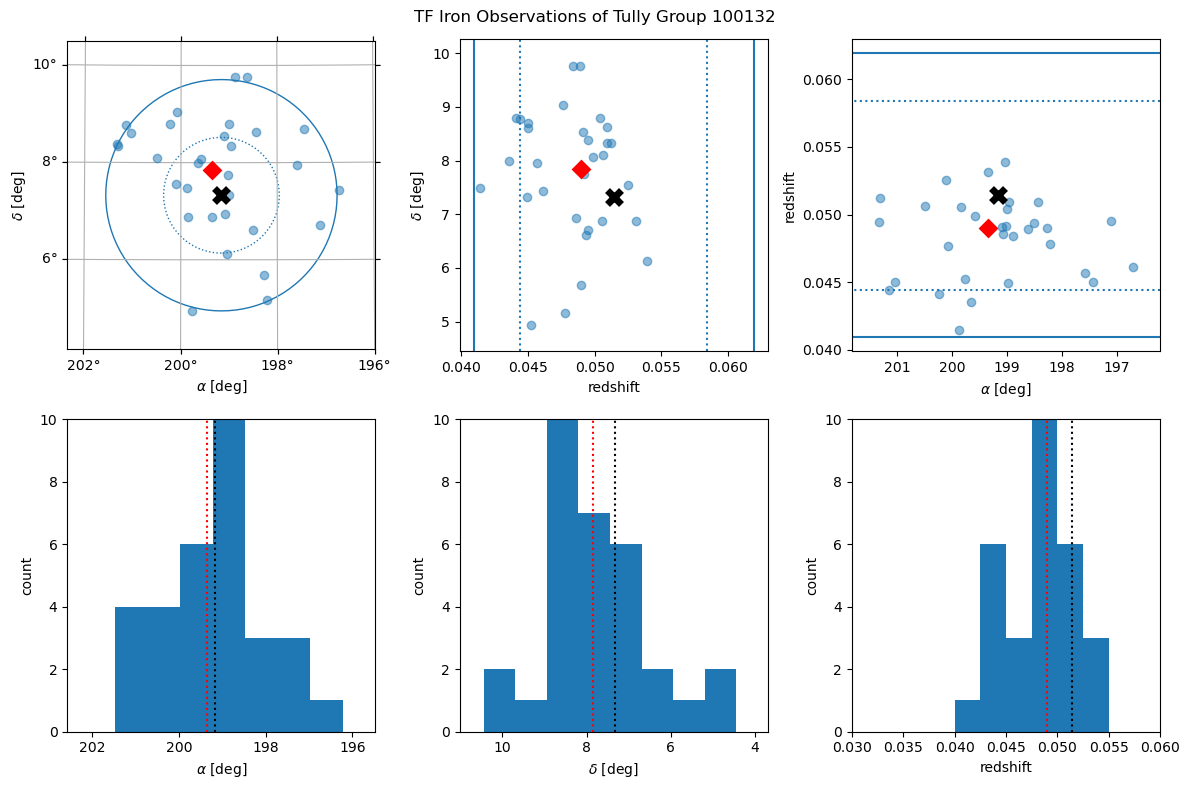

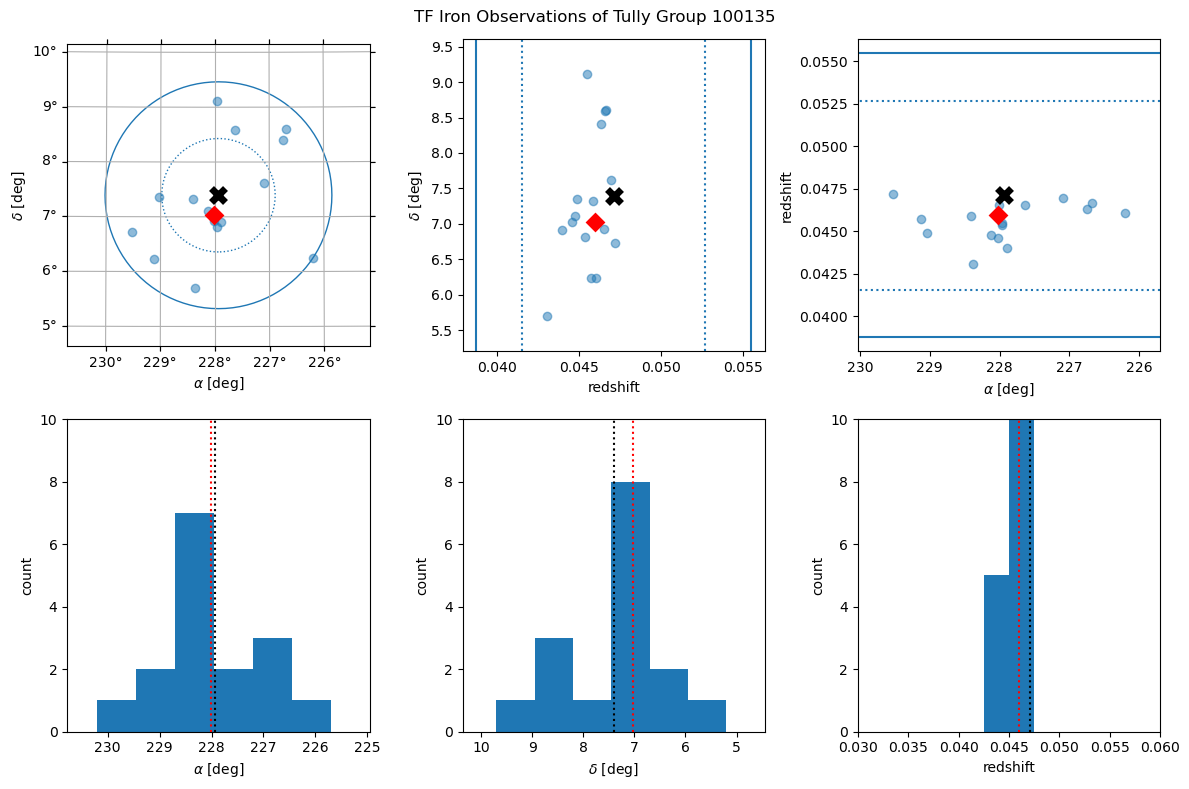

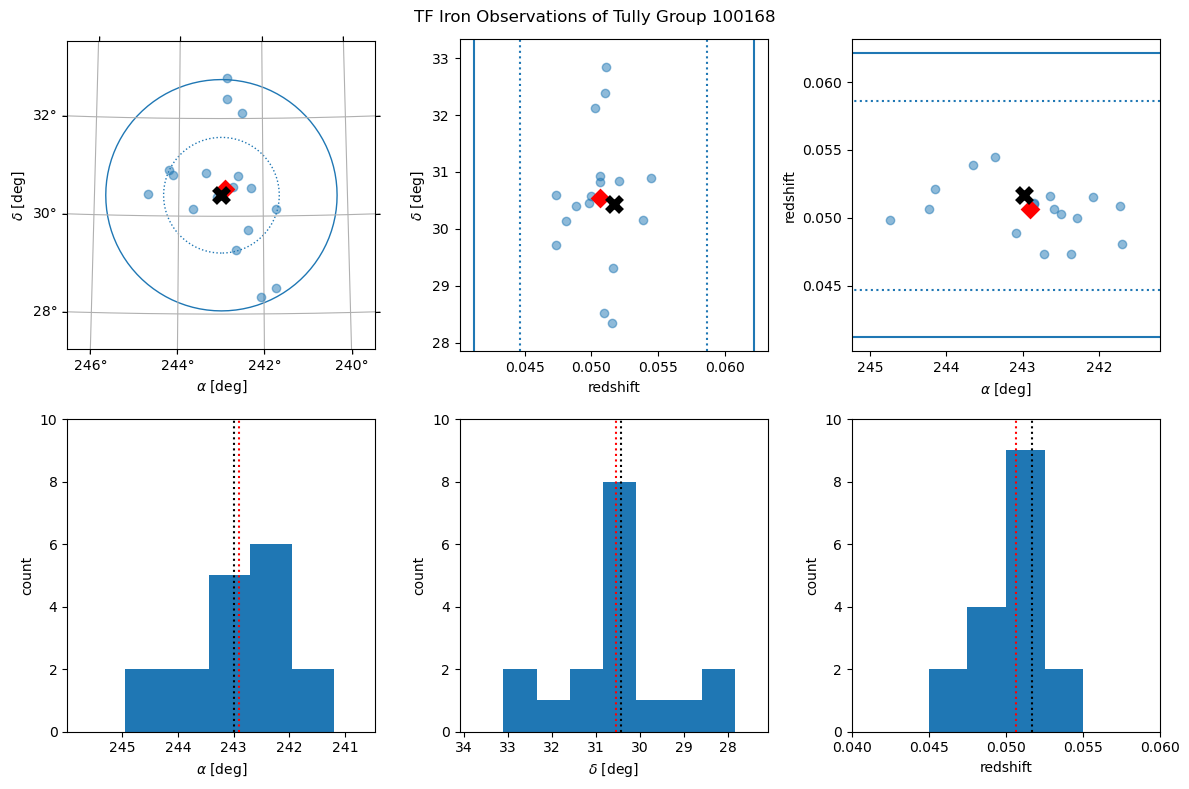

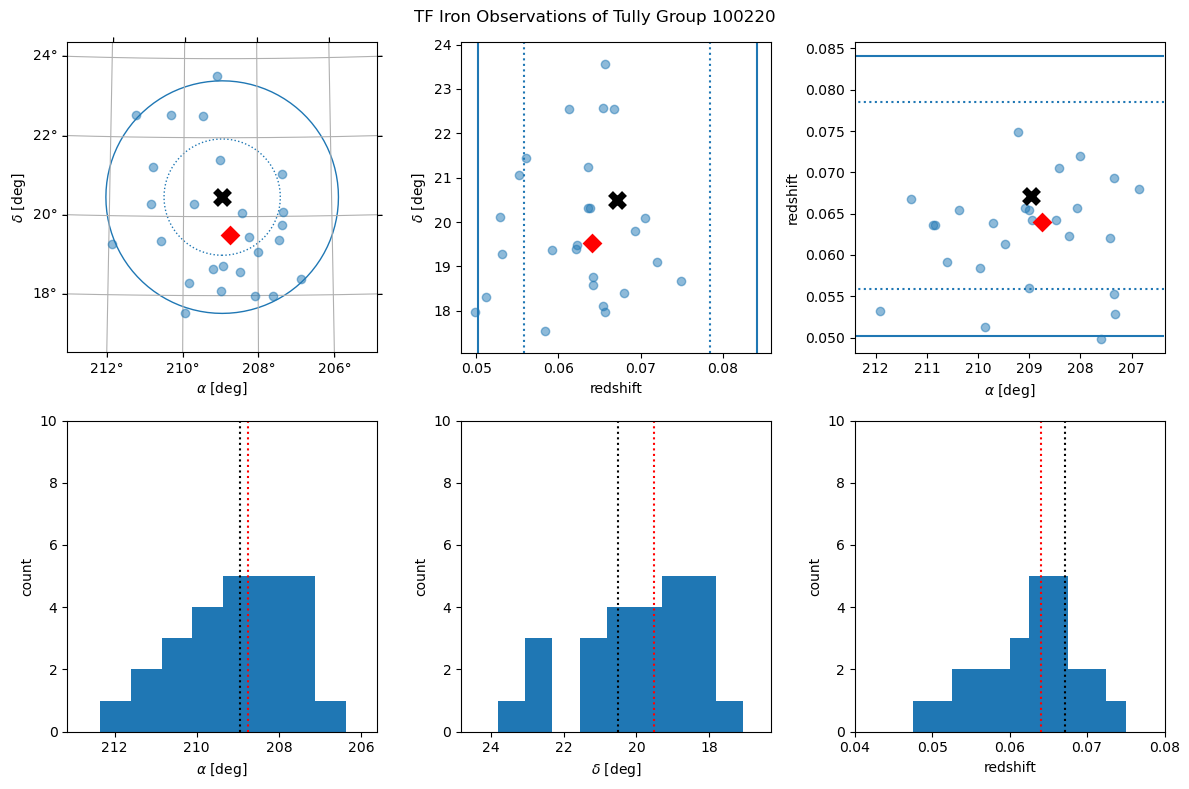

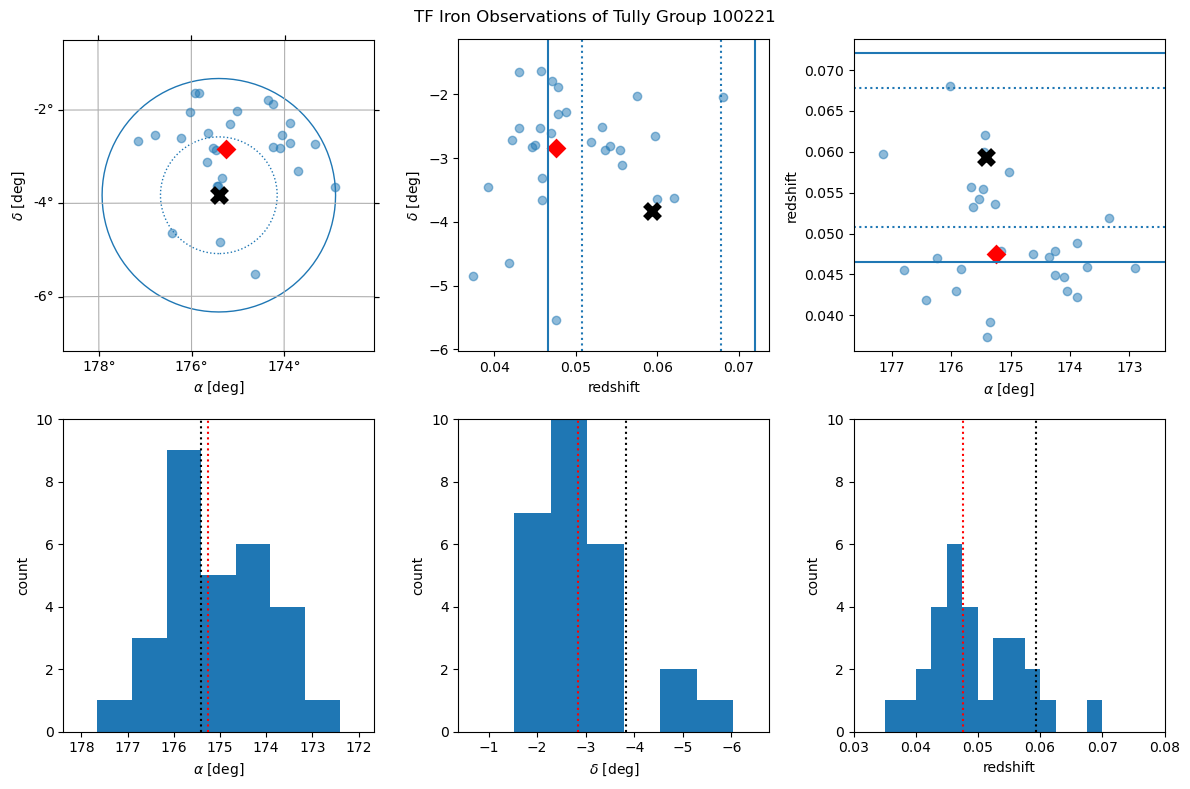

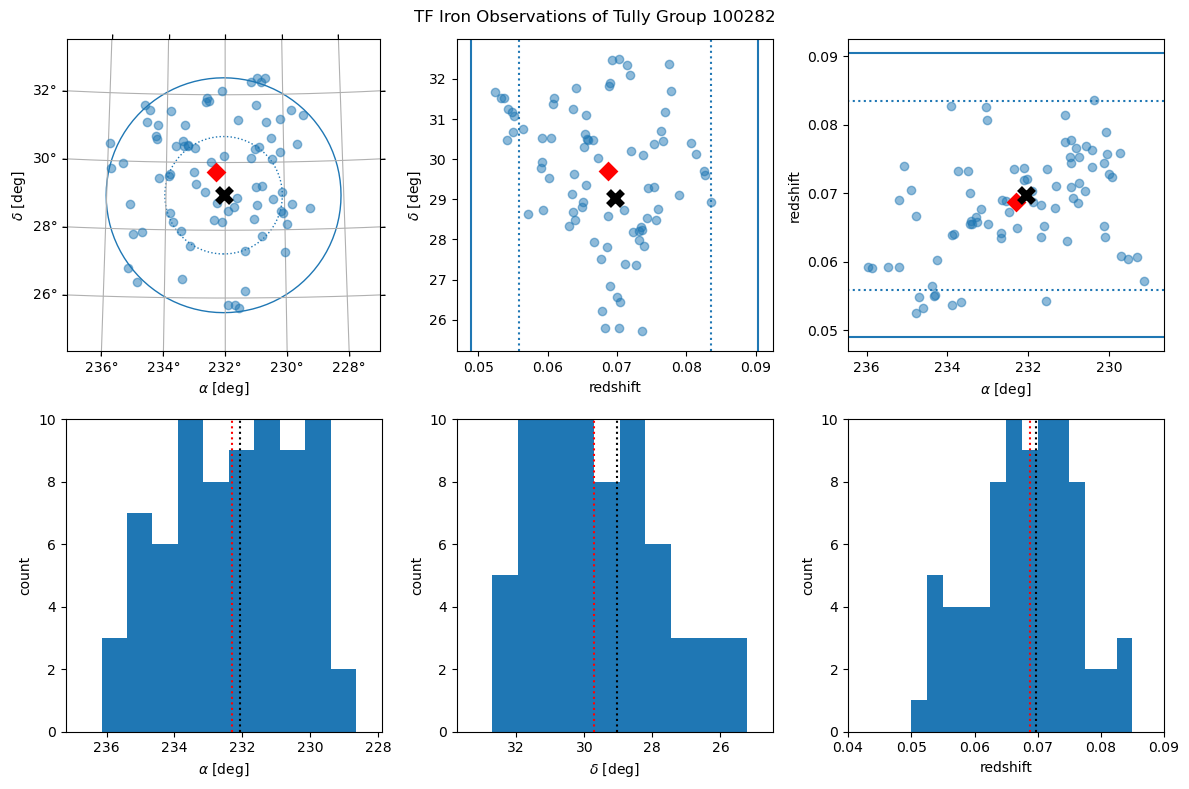

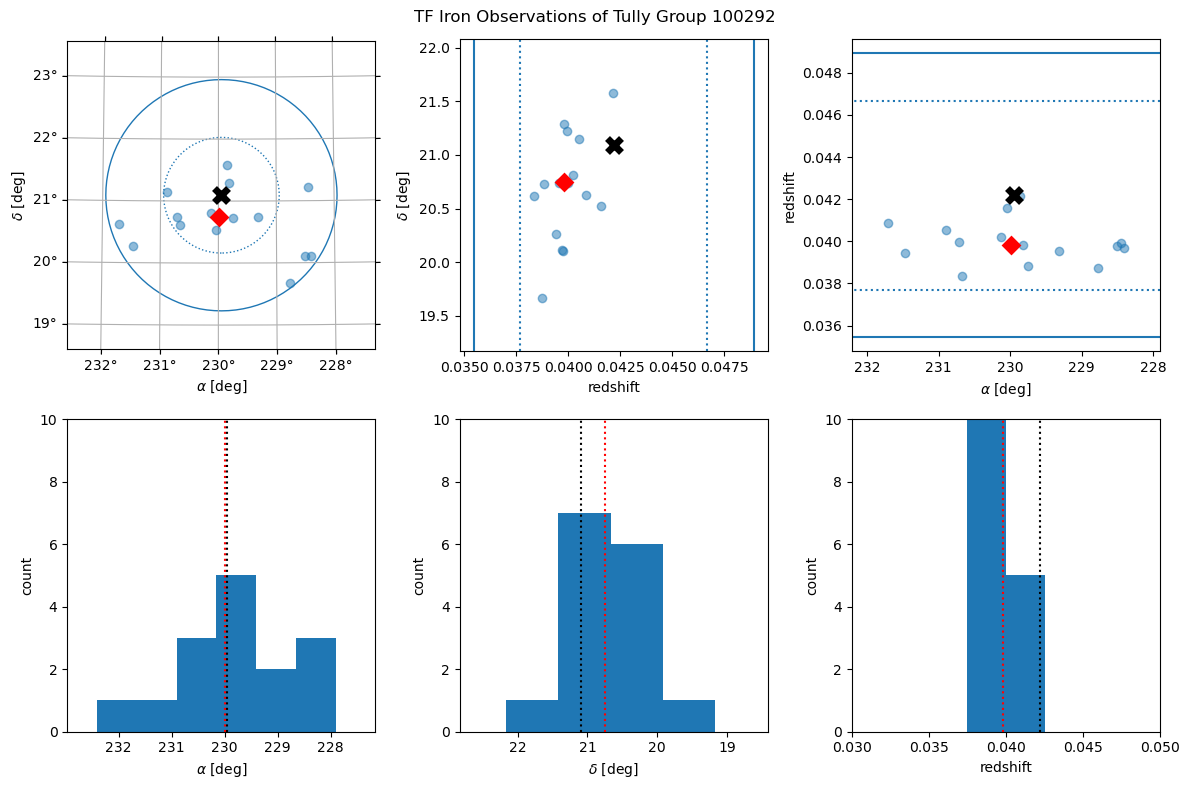

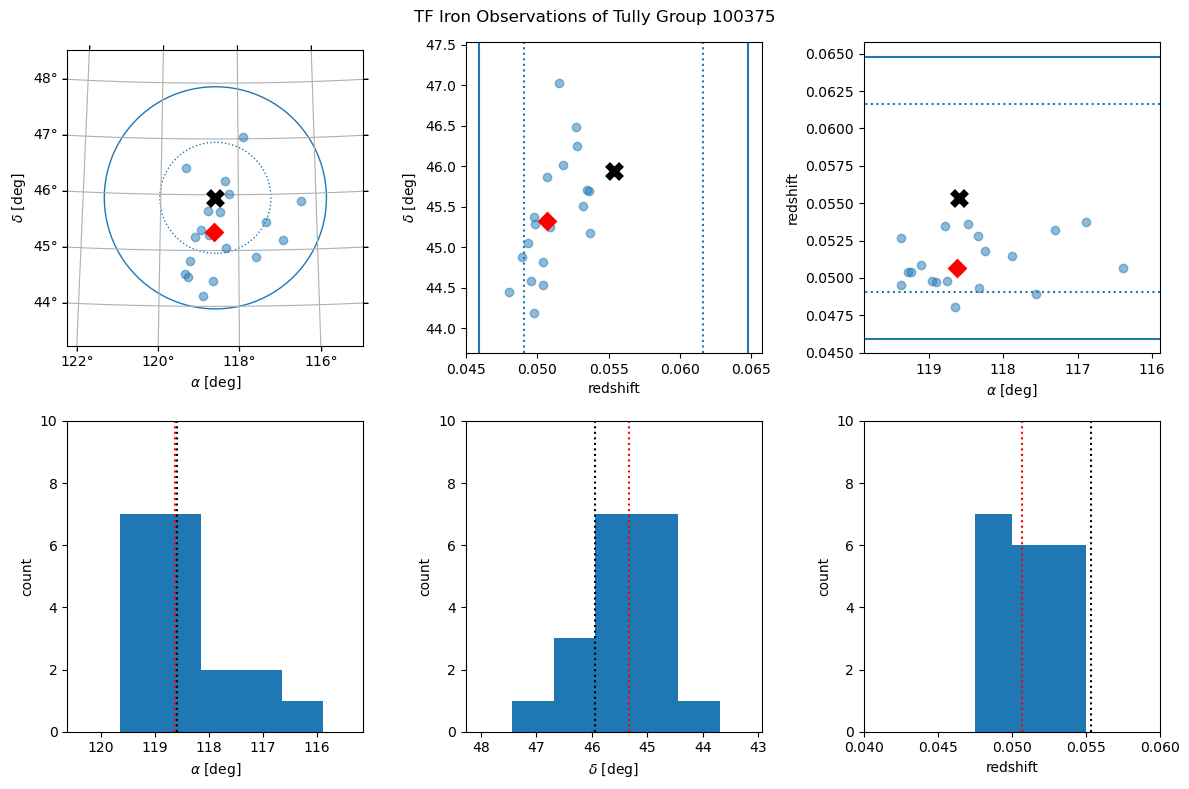

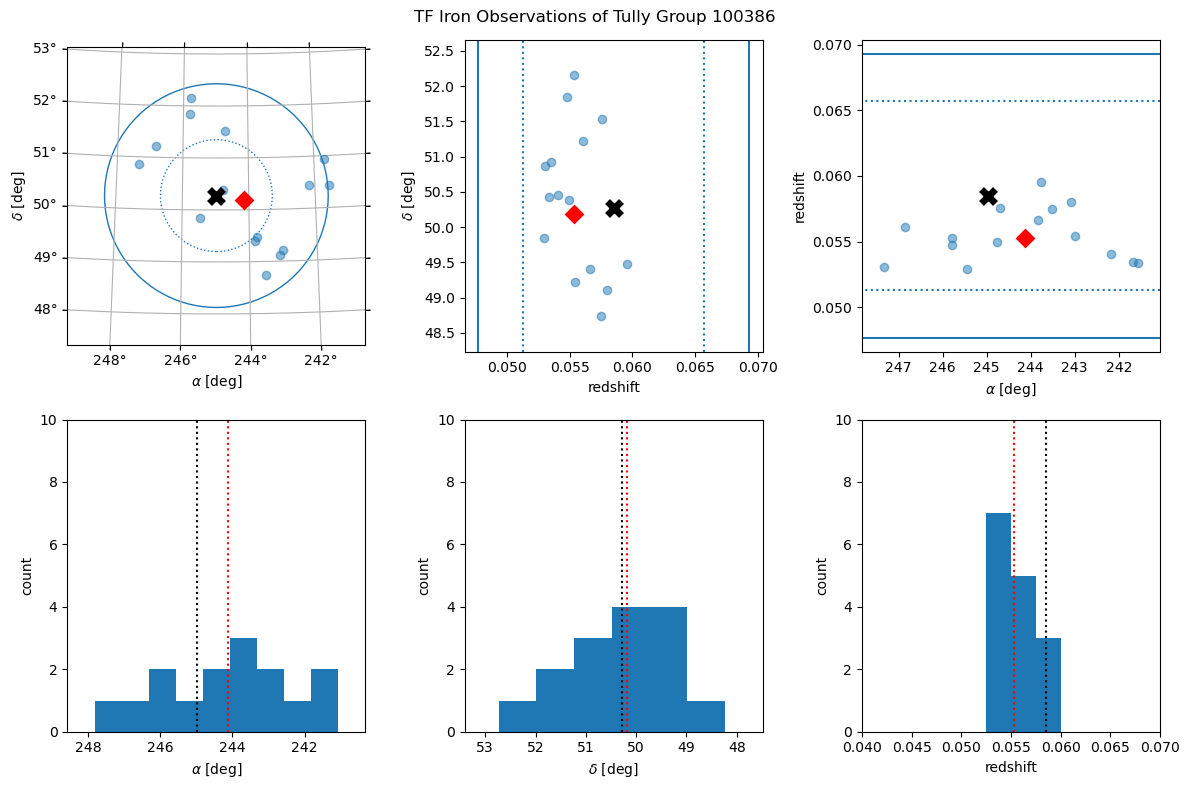

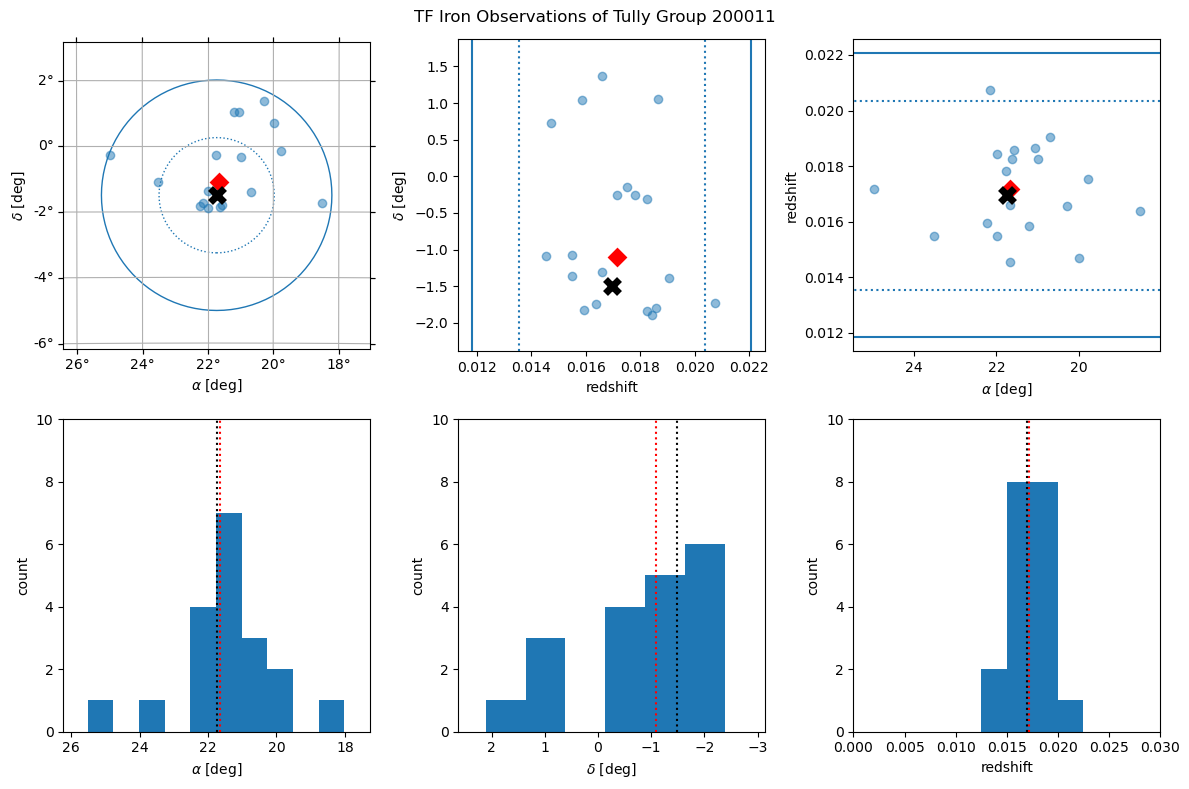

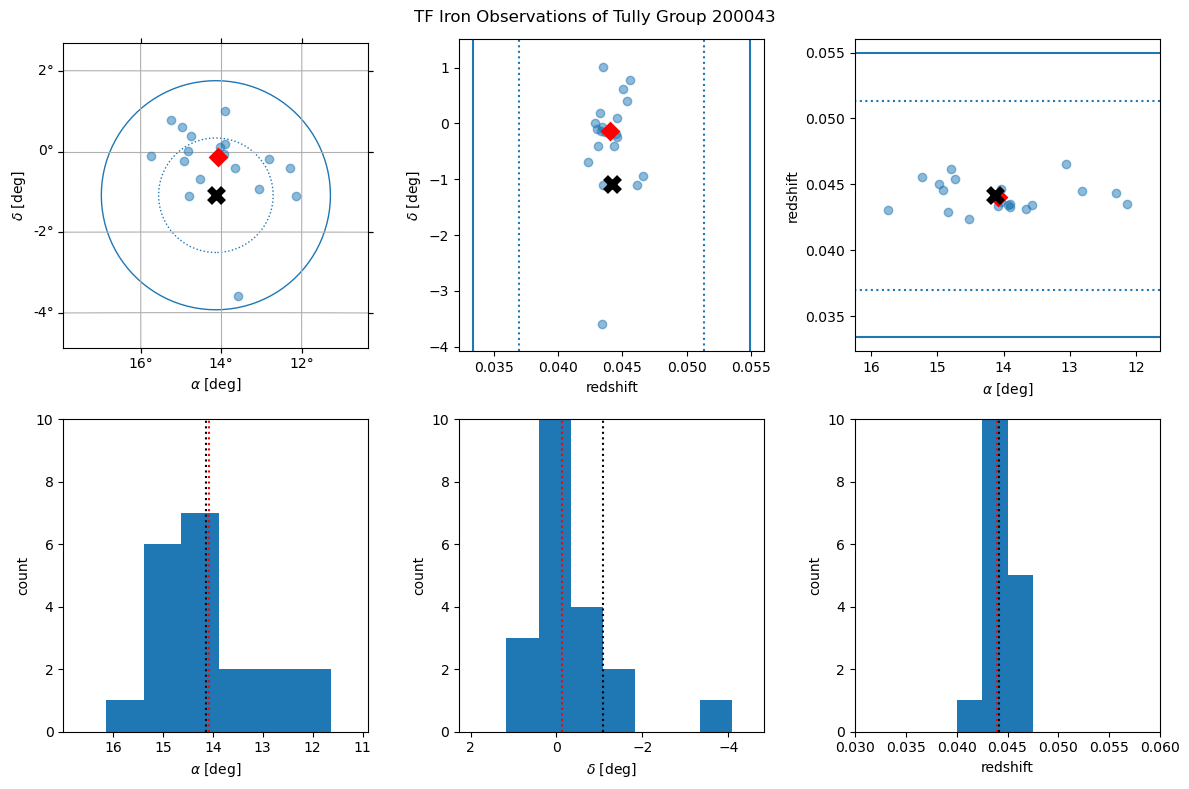

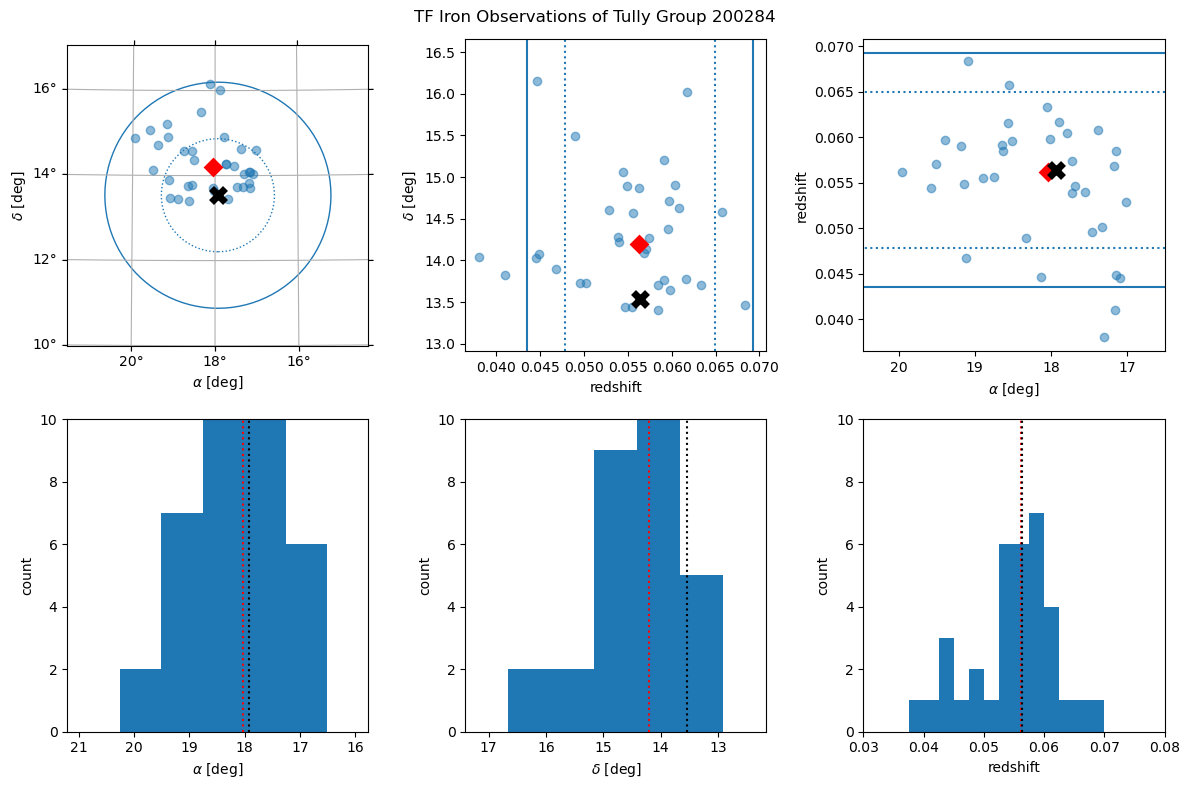

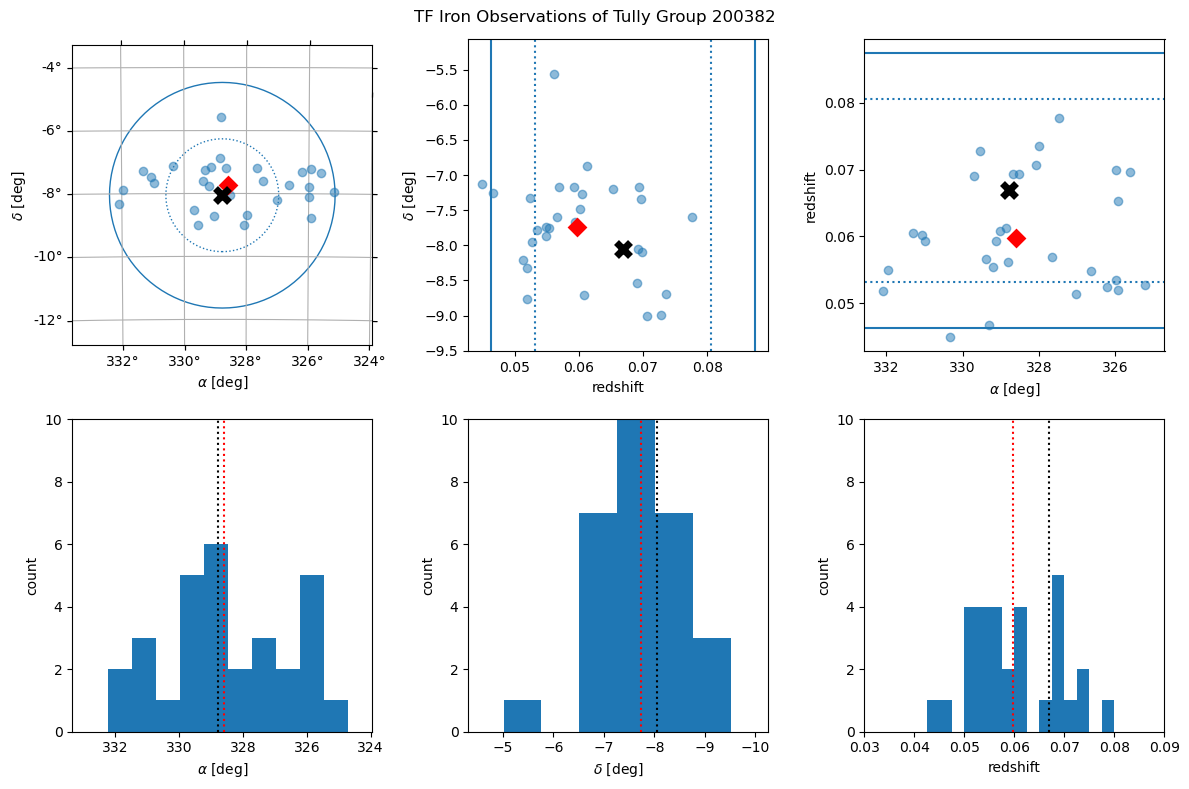

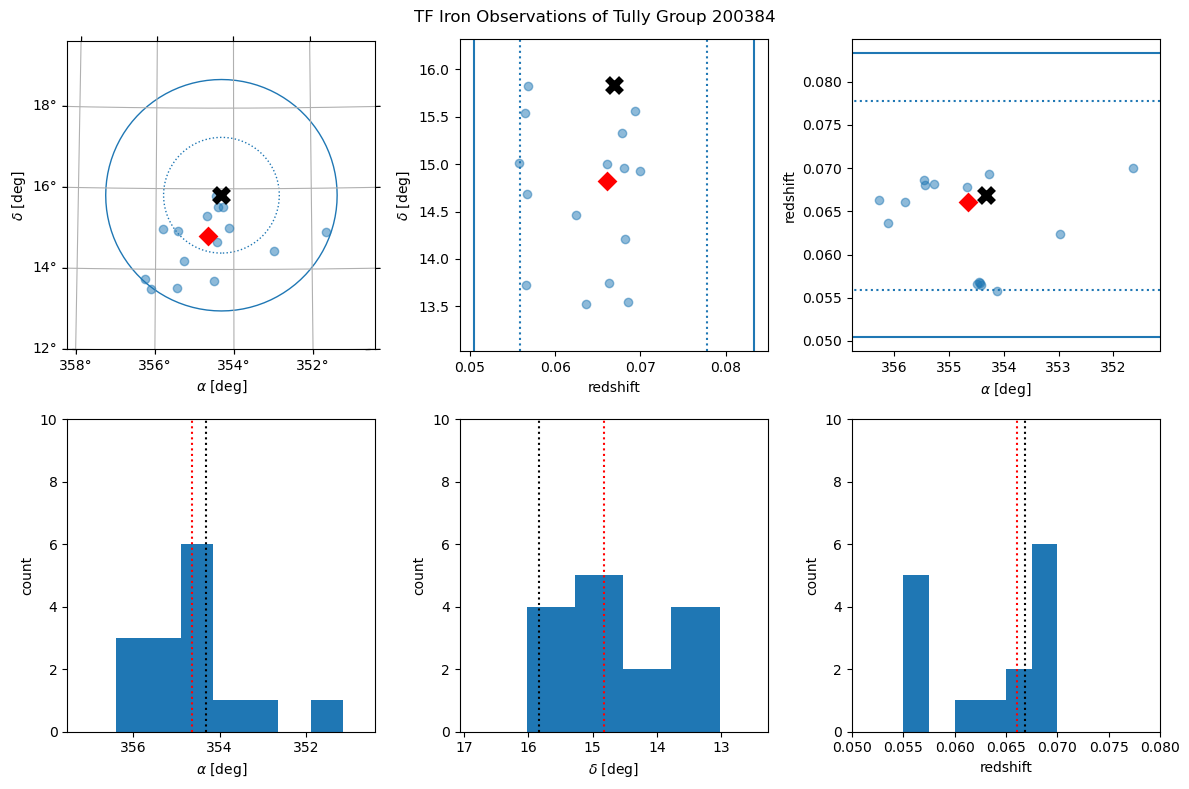

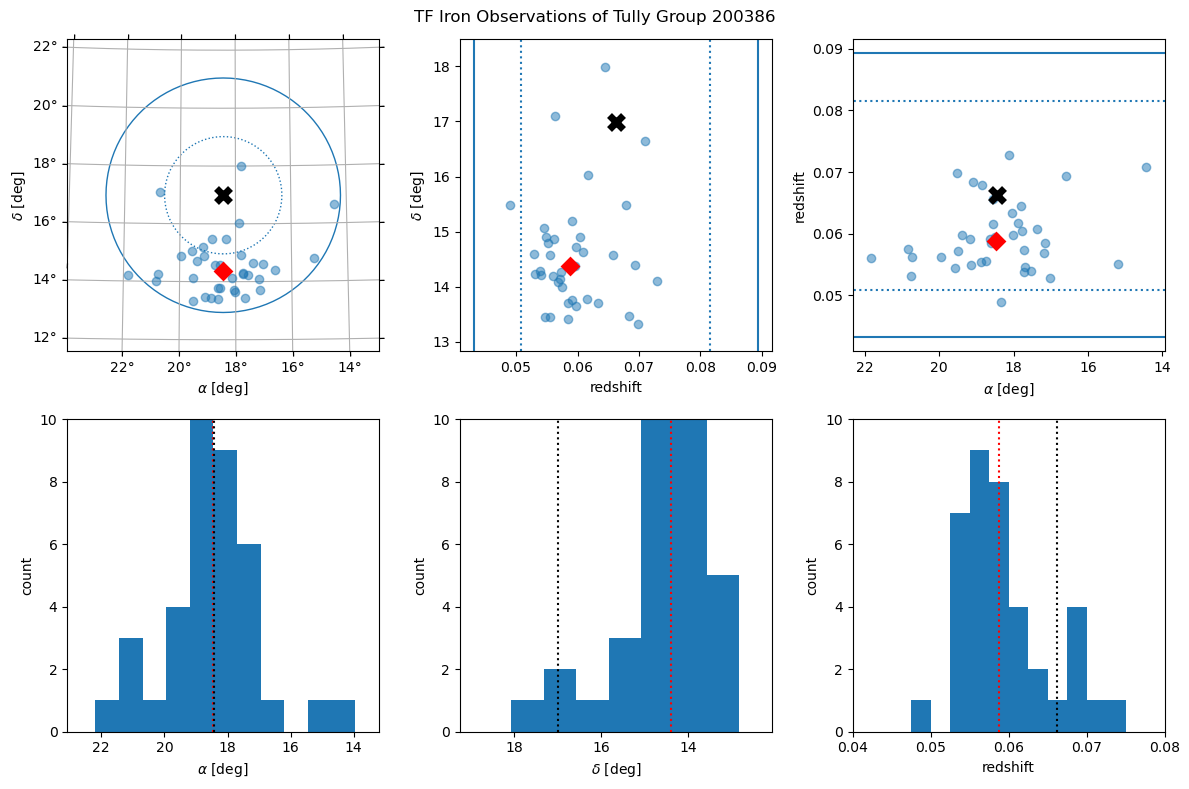

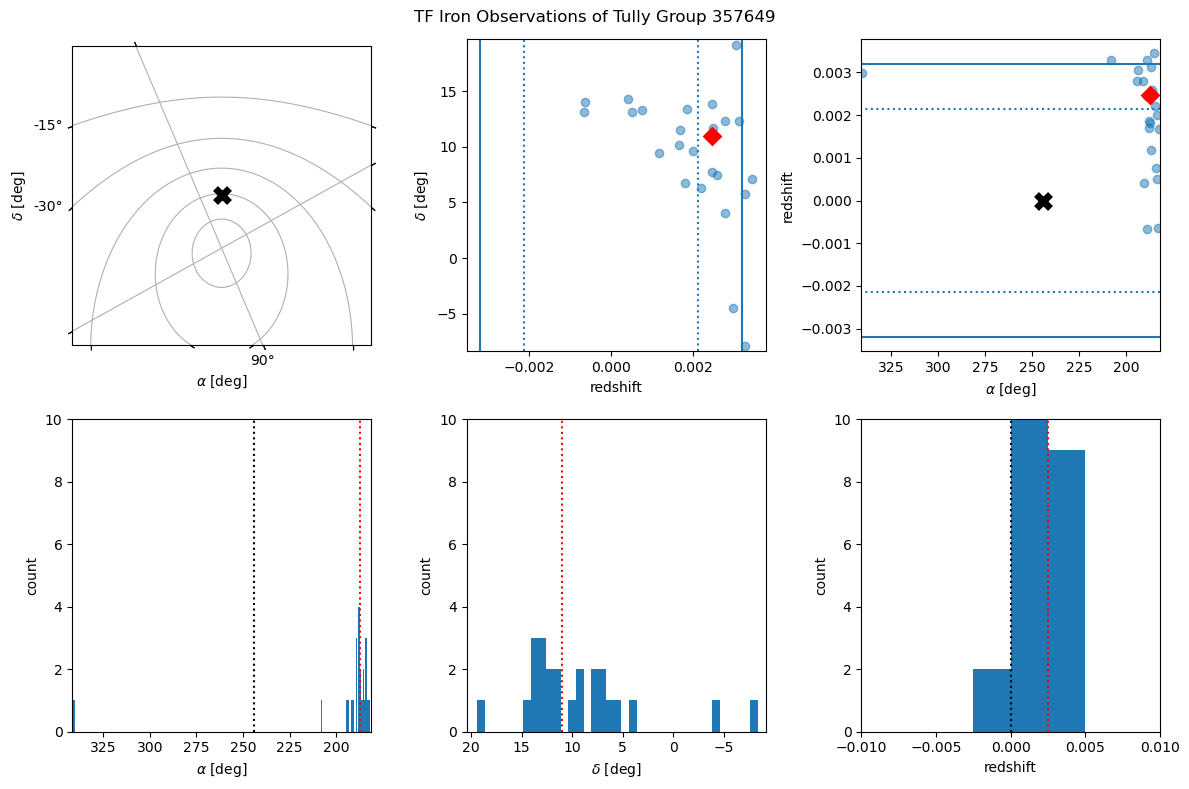

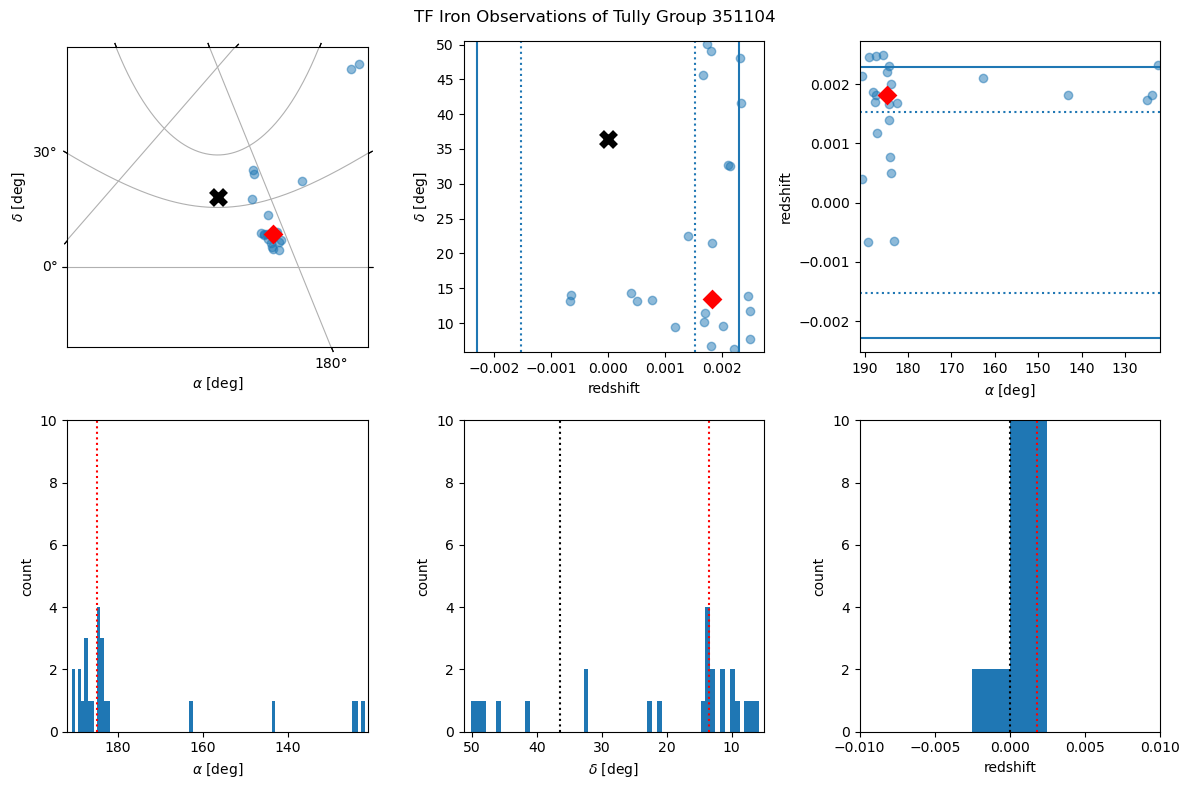

In [38]:
for cluster_id in sga_clusters.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])

# Apply Cluster Selection

Plot the clusters as a function of $\Delta\theta/\angle(R_{2t})$ versus $\Delta v/\sigma_P$. The quantities are:
* $\Delta\theta$: the angular separation between the median position of the DESI observations and the cluster center reported in Tully 2015.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster, reported in Tully 2015.

A reasonable selection appears to be

1. $\Delta v/ \sigma_P < 1$
2. $\Delta\theta / R_{2t} < 1$

100001        85.027 km/s     886.000 km/s       0.096       2.370 deg       1.699 deg       0.930
100005       199.190 km/s     707.000 km/s       0.282       0.471 deg       1.308 deg       0.240
100007       332.602 km/s    1261.000 km/s       0.264       0.322 deg       1.448 deg       0.148
100032       476.123 km/s     479.000 km/s       0.994       0.486 deg       0.807 deg       0.402
100042       143.833 km/s     451.000 km/s       0.319       0.274 deg       0.774 deg       0.236
100051       114.589 km/s     268.000 km/s       0.428       0.204 deg       0.761 deg       0.179
100058       336.152 km/s     326.000 km/s       1.031       0.040 deg       0.750 deg       0.036
100077        47.691 km/s    2041.000 km/s       0.023       0.147 deg       1.295 deg       0.076
100094       353.630 km/s     620.000 km/s       0.570       0.845 deg       0.724 deg       0.779
100098       169.088 km/s     384.000 km/s       0.440       0.066 deg       0.681 deg       0.064
100125    

/tmp/ipykernel_1180892/1817881169.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
/tmp/ipykernel_1180892/1817881169.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
/tmp/ipykernel_1180892/1817881169.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
/tmp/ipykernel_1180892/1817881169.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian


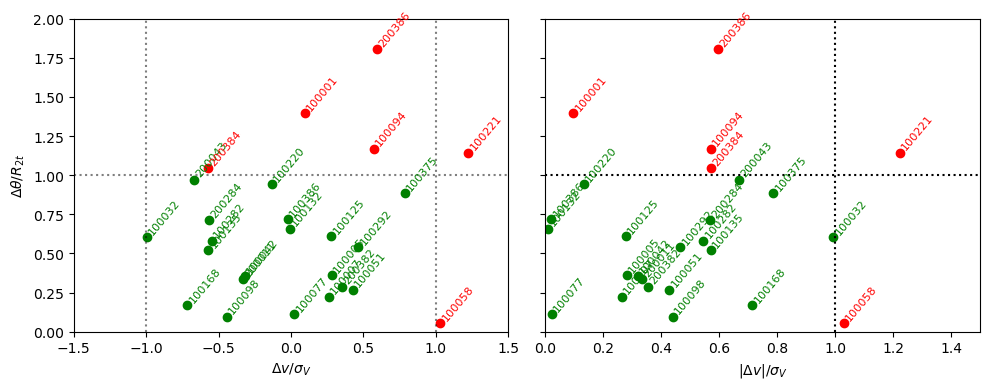

In [39]:
keep_cluster = []
dv_sigmaV = []
dtheta_R2t = []
cluster_ids = []

for cluster_id, sga_ids in sga_clusters.items():
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_v = 100 * 10**(0.2*(clusters['DM'][idx][0] - 25)) / (1 + clusters['HRV'][idx][0]/c_kms)
    cluster_sigma = clusters['sigV'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')
    
    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgatab['SGA_ID'], sga_ids)
    z_sga = sgatab['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Compute the angle and velocity ratios:
    delta_v = cluster_v - c_kms*z_sga_median
    _dv_sigV = delta_v / cluster_sigma
    dv_sigmaV.append(_dv_sigV)

    delta_theta = sga_coords_median.separation(cluster_coord).to('rad')
    _dth_R2t = delta_theta / cluster_R2t_angle
    dtheta_R2t.append(_dth_R2t)

    cluster_ids.append(cluster_id)

    #- Print results:
    print(f'{cluster_id:<8d}{np.abs(delta_v):12.3f} km/s{cluster_sigma:12.3f} km/s{np.abs(delta_v)/cluster_sigma:12.3f}' \
          f'{delta_theta.to("deg"):12.3f}{cluster_R2t_angle.to("deg"):12.3f}{delta_theta / (1.5*cluster_R2t_angle):12.3f}')

dv_sigmaV = np.asarray(dv_sigmaV)
dtheta_R2t = np.asarray(dtheta_R2t)
cluster_ids = np.asarray(cluster_ids)

#- Apply selection
dvcut = 1
dthcut = 1

select = (np.abs(dv_sigmaV) < dvcut) & (dtheta_R2t < dthcut)

#- Plot results

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
ax = axes[0]
ax.scatter(dv_sigmaV[select], dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(dv_sigmaV[select], dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(dv_sigmaV[~select], dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(dv_sigmaV[~select], dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
ax.set(xlabel=r'$\Delta v/\sigma_V$',
       xlim=(-1.5, 1.5),
       ylabel=r'$\Delta\theta/R_{2t}$',
       ylim=(0,2))

ax = axes[1]
ax.scatter(np.abs(dv_sigmaV[select]), dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(np.abs(dv_sigmaV[select]), dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(np.abs(dv_sigmaV[~select]), dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(np.abs(dv_sigmaV[~select]), dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k')
ax.axvline(-dvcut, ls=':', color='k')
ax.axhline(dthcut, ls=':', color='k')
ax.set(xlabel=r'$|\Delta v|/\sigma_V$',
       xlim=(0, 1.5));


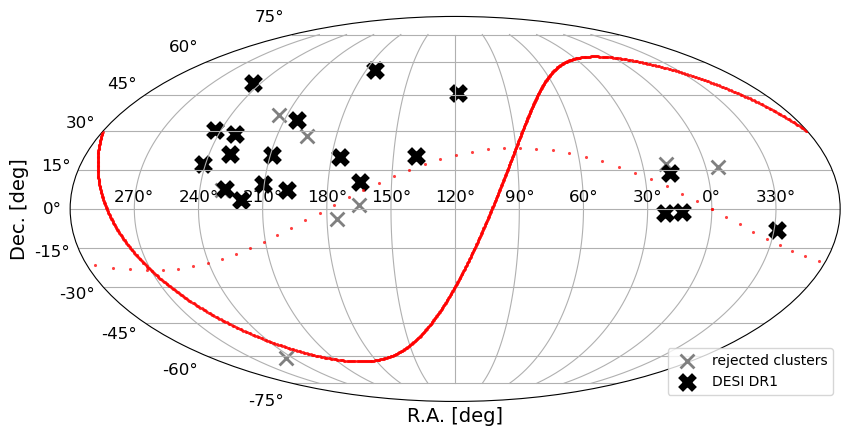

In [40]:
nest_ids = np.asarray(list(sga_clusters.keys()))
good_idx = np.in1d(clusters['Nest'], nest_ids[select])
bad_idx = np.in1d(clusters['Nest'], nest_ids[~select])
good_cluster_coords = SkyCoord(clusters['SGLON'][good_idx], clusters['SGLAT'][good_idx], unit='deg', frame='supergalactic')
bad_cluster_coords = SkyCoord(clusters['SGLON'][bad_idx], clusters['SGLAT'][bad_idx], unit='deg', frame='supergalactic')

ax = init_sky()

ax.scatter(ax.projection_ra(bad_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(bad_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=2,
           color='gray', 
           label='rejected clusters')
ax.scatter(ax.projection_ra(good_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(good_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=5,
           color='black', 
           label='DESI DR1')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend(loc='lower right')

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_clusters_AnthonyUpdates_sky.png', dpi=150, facecolor='none');

In [41]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

 1  100001  34 galaxies  N
 2  100005  18 galaxies  Y
 3  100007 131 galaxies  Y
 4  100032  21 galaxies  Y
 5  100042  22 galaxies  Y
 6  100051  17 galaxies  Y
 7  100058  20 galaxies  N
 8  100077  79 galaxies  Y
 9  100094  23 galaxies  N
10  100098  16 galaxies  Y
11  100125  29 galaxies  Y
12  100132  31 galaxies  Y
13  100135  16 galaxies  Y
14  100168  17 galaxies  Y
15  100220  26 galaxies  Y
16  100221  29 galaxies  N
17  100282  80 galaxies  Y
18  100292  15 galaxies  Y
19  100375  19 galaxies  Y
20  100386  15 galaxies  Y
21  200011  19 galaxies  Y
22  200043  20 galaxies  Y
23  200284  35 galaxies  Y
24  200382  30 galaxies  Y
25  200384  15 galaxies  N
26  200386  38 galaxies  N
27  357649  24 galaxies  N
28  351104  24 galaxies  N


## Plot Clusters that Failed

In [42]:
# for cluster_id in sga_clusters.keys():
#     if cluster_id in cluster_ids[~select]:
#         fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
#         # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Clusters that Passed

In [43]:
# for cluster_id in sga_clusters.keys():
#     if cluster_id in cluster_ids[select]:
#         fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
#         # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [44]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for cluster_id, sga_ids in sga_clusters.items():
    if cluster_id in cluster_ids[select]:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        caltab = clustertab if caltab is None else vstack([caltab, clustertab])
    else:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

# caltab.write('SGA-2020_jura_Vrot_cluster_calib_VI_Tully_full.fits', overwrite=True)
# caltab.write('SGA-2020_jura_Vrot_cluster_calib_VI_Tully_nooverlap.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

<Table length=656>
CLUSTER_ID   SGA_ID  ...      V_0p4R26         V_0p4R26_err   
  int64     float64  ...      float64            float64      
---------- --------- ... ------------------ ------------------
    100005   38348.0 ...  61.45029057703735 1.1829777882644084
    100005   90188.0 ...  44.53324303394772  23.71988739054273
    100005  182436.0 ...  84.84642966467045 3.7150468213078525
    100005  193860.0 ...   98.4257053747051 1.7787600075166177
    100005  305899.0 ...  114.8357557033563 18.019290956912805
    100005  310018.0 ...  88.50385400370305 1.3432023788259895
    100005  489429.0 ... 113.97318091729522  4.084668891931863
    100005  581176.0 ... 113.89518410653642 1.2906001105581966
    100005  650456.0 ... 57.540173005096136  5.210118734052597
    100005  791810.0 ... 109.54352749365962  2.627171952254192
       ...       ... ...                ...                ...
    200382 1109236.0 ... 222.63712716664668  11.63440525962132
    200382 1118056.0 ... 131.67965528472087  2.992605615692226
    200382 1174533.0 ... 114.24645184371741  3.968627340115765
    200382 1277302.0 ... 271.47809031281673  4.019479600547374
    200382 1281563.0 ... 142.81238911597572 1.0531496888508618
    200382 1347847.0 ... 227.42157264559913  4.312151559119431
    200382 1350407.0 ... 191.91974102461703    8.2721001062205
    200382 1360609.0 ... 228.99023458624168  1.181740758500999
    200382 1362325.0 ... 185.60611492621769 3.1922637437527523
    200382 1375484.0 ... 183.90565327576678  5.626717420292267

In [37]:
# # Save SGA IDs for each cluster that is part of the calibration (for Alex's Bayesian calibration)
# for cluster in np.unique(caltab['CLUSTER_ID']):
#     output_filename = 'output_' + str(cluster) + '.txt'
#     # SGA_IDs_in_cluster = Table()
#     # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
#     caltab[['SGA_ID']][caltab['CLUSTER_ID'] == cluster].write(output_filename, 
#                                                               format='ascii.commented_header', 
#                                                               overwrite=True)

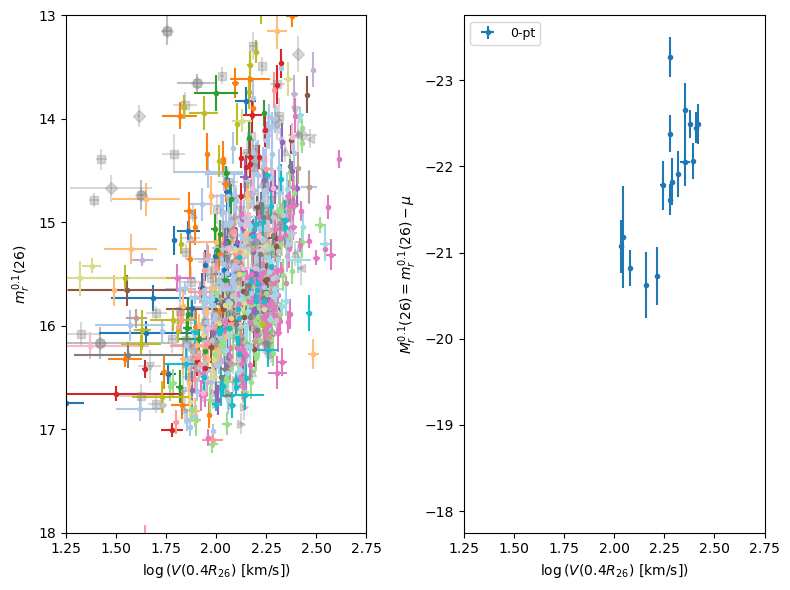

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#- Plot galaxies with failed cluster selections.
_cluster_ids = np.unique(rejtab['CLUSTER_ID'])
markers = 'sDv^<>'
for j, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18, 13],
       ylabel=r'$m_r^{0.1} (26)$')
# ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# # fig.savefig('Figures/TF_Y3_cluster_calibration_0pt.png', dpi=150);

# Apply the Joint TFR Fit

In [46]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])
weights.append(np.array(1/zeroptab['MAX_VOL_FRAC']))

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_cluster])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_cluster]))

logV0 = 2.1420628416139014


In [47]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -68870.02332861393
     jac: array([ 0.15570549,  0.16443663,  0.02328306, -0.96042633,  0.16007105,
        0.48748912,  0.01600711, -0.65920171, -0.15570548,  0.24738254,
        0.53114486,  0.0509317 , -0.00582077, -0.11641531,  0.17025739,
        0.07421476,  0.00727596,  0.10768416,  0.02328306, -0.08294591,
       -0.2546585 , -0.15570548,  0.55588316])
 message: 'Optimization terminated successfully.'
    nfev: 75201
     nit: 216
 success: True
       x: array([ -6.63995059, -21.00924651,  14.05019734,  15.06302578,
        13.94406397,  14.76262067,  14.44867657,  16.13864803,
        14.57081377,  14.87503503,  15.56198001,  15.50007883,
        15.81960653,  16.1879771 ,  16.37664707,  15.35964841,
        15.71025807,  15.85459915,  13.39290008,  15.00751307,
        15.88199253,  16.27944777,   0.61842587])
Ndim: 23 21


100%|██████████| 1000/1000 [01:36<00:00, 10.37it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [80.34628216 87.93021749 79.36963821 82.72014668 83.87325978 83.22291276
 80.27505063 80.26420699 84.00793956 83.78991229 85.0850106  78.33697242
 84.9734644  82.62850651 73.88051388 83.49923753 80.35288002 78.03846246
 81.72041011 77.84205762 84.05671814 85.64909137 83.25050191] / 4396.51087449382


100%|██████████| 1000/1000 [01:37<00:00, 10.28it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.73536062 111.28937226 111.85981282  99.45672174 105.22256508
 109.66998826 117.43430252 103.11698972 109.50992409 109.1882167
 104.87353022 103.43616353 110.08813551 104.20098982 102.95058899
 122.32981065 117.53334305 100.00818316 113.02383676 100.24158714
 115.3002367  105.59531092 105.44771079] / 6116.49053255297


100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [122.46503813 132.85802013 125.11158289 110.38829078 134.29465776
 122.04670706 126.49289083 111.39094859 123.45174657 130.45752142
 126.87969288 141.00052455 128.13111718 138.88130978 117.4712499
 130.12387531 125.08676429 132.43648743 122.92846693 130.44048826
 133.99396627 140.86919362 122.49541659] / 7050.0262277476495


100%|██████████| 1000/1000 [01:35<00:00, 10.47it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [139.56680129 142.24583008 157.98939423 123.32388602 147.0290736
 133.35872788 154.7748644  136.05808418 145.31197364 142.79047681
 133.88947889 145.22982036 138.69114575 149.84859078 121.52922276
 144.43342454 148.09941413 143.78369675 139.24258443 144.55954571
 139.09090693 136.97851319 150.58222362] / 7899.469711646576


100%|██████████| 1000/1000 [01:38<00:00, 10.17it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [159.02138177 159.2557316  154.43497745 122.36218235 165.12261416
 156.91360174 163.56325894 144.50693011 147.89597192 152.43538806
 161.10344741 151.59196356 152.65941122 151.09418986 152.81845666
 151.31244609 162.12172222 145.13567468 154.78820397 150.78276137
 159.5177107  151.24781058 172.18438041] / 8609.219020368375


100%|██████████| 1000/1000 [01:36<00:00, 10.41it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [164.8216669  166.14887729 152.0755432  125.8648498  163.29049238
 162.09391329 171.1258627  145.96923373 159.73034266 172.30561876
 166.85224924 157.31093777 167.68639978 158.91520303 141.91318729
 167.34992355 164.04377823 155.20853361 168.94415227 149.99410115
 154.00087308 174.37292946 169.56325507] / 8718.646473065386


100%|██████████| 1000/1000 [01:35<00:00, 10.44it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [175.48656655 177.95835353 173.20357784 135.3051667  179.09565936
 169.25361701 185.60098003 149.94624552 168.95462262 185.16997184
 186.28725883 181.50016162 196.73202595 170.94475073 150.70350417
 191.74182257 168.25830266 174.76577347 189.59606277 157.31786584
 169.05136009 183.59308649 181.4465596 ] / 9836.601297491152


100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [201.62018945 180.75337185 184.19979546 134.21637748 167.61546056
 167.88920436 189.57451675 146.6895926  179.57335103 181.46676307
 188.65347438 184.41681302 197.3084542  184.75481202 156.35672823
 198.55346547 173.73008656 172.74200956 181.4233407  173.44365316
 177.59629866 182.52766683 195.388639  ] / 10081.009472294974


100%|██████████| 1000/1000 [01:36<00:00, 10.36it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [210.98805995 195.75111458 191.58799769 142.92325305 176.35115009
 185.2524466  194.16173208 154.36613533 174.96911974 177.52391028
 189.76913139 198.36480233 212.10312276 188.78823472 166.73131923
 209.15362494 186.45457667 189.87748618 186.44737896 190.32214441
 193.4968156  192.21351895 206.66785151] / 10605.156138175942


100%|██████████| 1000/1000 [01:35<00:00, 10.51it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [210.58871714 198.99927232 194.35453197 151.56421587 172.12517084
 201.79781548 195.92892821 155.50676996 183.90834092 195.65296041
 185.09912691 205.18876353 206.97461948 192.78507743 168.68687403
 205.71566343 191.52487748 186.89548739 195.26671116 186.41148302
 212.1970562  191.7004168  199.78648851] / 10609.852810137485


100%|██████████| 1000/1000 [01:35<00:00, 10.49it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [218.74095077 208.70524199 206.36117835 164.66446203 185.82698789
 225.80455295 208.83045513 162.3793001  189.30572579 205.78737789
 204.51079483 217.63890536 208.79015336 204.09094244 172.97020404
 213.89943569 220.01025113 189.22285833 211.90201884 199.68375124
 224.71630802 206.39864095 199.53121015] / 11290.22764741341


100%|██████████| 1000/1000 [01:37<00:00, 10.23it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [214.53087163 211.64384278 209.86285953 167.42051207 183.95883691
 203.82340331 198.43914117 168.08036132 196.78031749 203.572858
 201.37324817 216.75589024 206.0462266  203.14723629 188.9129155
 210.80339172 221.19745215 195.31225838 200.00161468 197.42202629
 231.73027458 207.1380697  199.98609548] / 11586.51372919031


100%|██████████| 1000/1000 [01:37<00:00, 10.30it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [220.61091923 217.36720562 220.05967837 169.0698629  199.57548318
 209.21861795 209.05485216 166.16969293 211.18663327 208.47506877
 204.27460921 222.88002985 213.1424521  201.57751037 187.0638778
 221.22942926 229.85341242 213.54867524 209.88901295 207.29679819
 236.57104023 216.55796889 212.34281381] / 11828.552011607933


100%|██████████| 1000/1000 [01:36<00:00, 10.36it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [224.75186559 223.66749165 225.34226586 168.54969047 199.78218306
 205.77706941 215.13193992 176.44102259 206.35154998 220.19618236
 209.2205813  222.62106213 212.36534715 194.69937871 183.69752766
 219.40777077 230.25931669 215.76586961 205.99052708 217.13610814
 236.38798737 208.13611146 213.39450333] / 11819.399368669798


100%|██████████| 1000/1000 [01:36<00:00, 10.40it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [220.18308247 226.95987746 233.72227076 171.52017082 208.31785823
 214.18702733 228.85019418 185.29363336 207.55959467 218.92764225
 211.69823945 234.94778459 214.58633958 193.85910762 184.27723543
 213.18129853 214.70805613 221.19661738 213.75617258 233.73169381
 244.5579541  213.75980278 211.13916802] / 12227.897704797033


100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [225.12596616 228.76410827 232.76101779 181.12828524 223.28579778
 226.4682312  228.44321796 182.98464204 201.5476316  222.38262747
 213.86385367 236.97594526 212.24236589 198.82111139 185.72139291
 214.9561173  223.58533154 219.82309751 217.80592751 234.31412707
 226.53431107 204.60843475 219.56151517] / 11848.797262772867


100%|██████████| 1000/1000 [01:39<00:00, 10.00it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [231.52795767 234.07454957 235.33108283 182.36617093 228.58672156
 226.01382698 233.14933373 184.55431115 216.97419781 223.61608071
 220.72502114 243.16652301 216.03155211 201.38089052 187.78381723
 215.19711599 224.17505492 226.46350425 230.67539242 232.11123456
 222.39613591 214.97234519 221.94060156] / 12158.326150630823


100%|██████████| 1000/1000 [01:36<00:00, 10.38it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [238.19140823 228.67921651 231.96882635 175.95719514 224.95700476
 231.00212337 234.22878289 189.34236747 215.00507581 216.35329686
 223.29228821 243.20422813 219.7921019  201.21142137 193.5403902
 216.19536285 235.28207816 225.97313433 220.6164343  233.63957329
 217.73581304 214.31332047 230.20990815] / 12160.211406494094


In [48]:
temp_outfile = open('cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_nooverlap_VI_primarySN.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

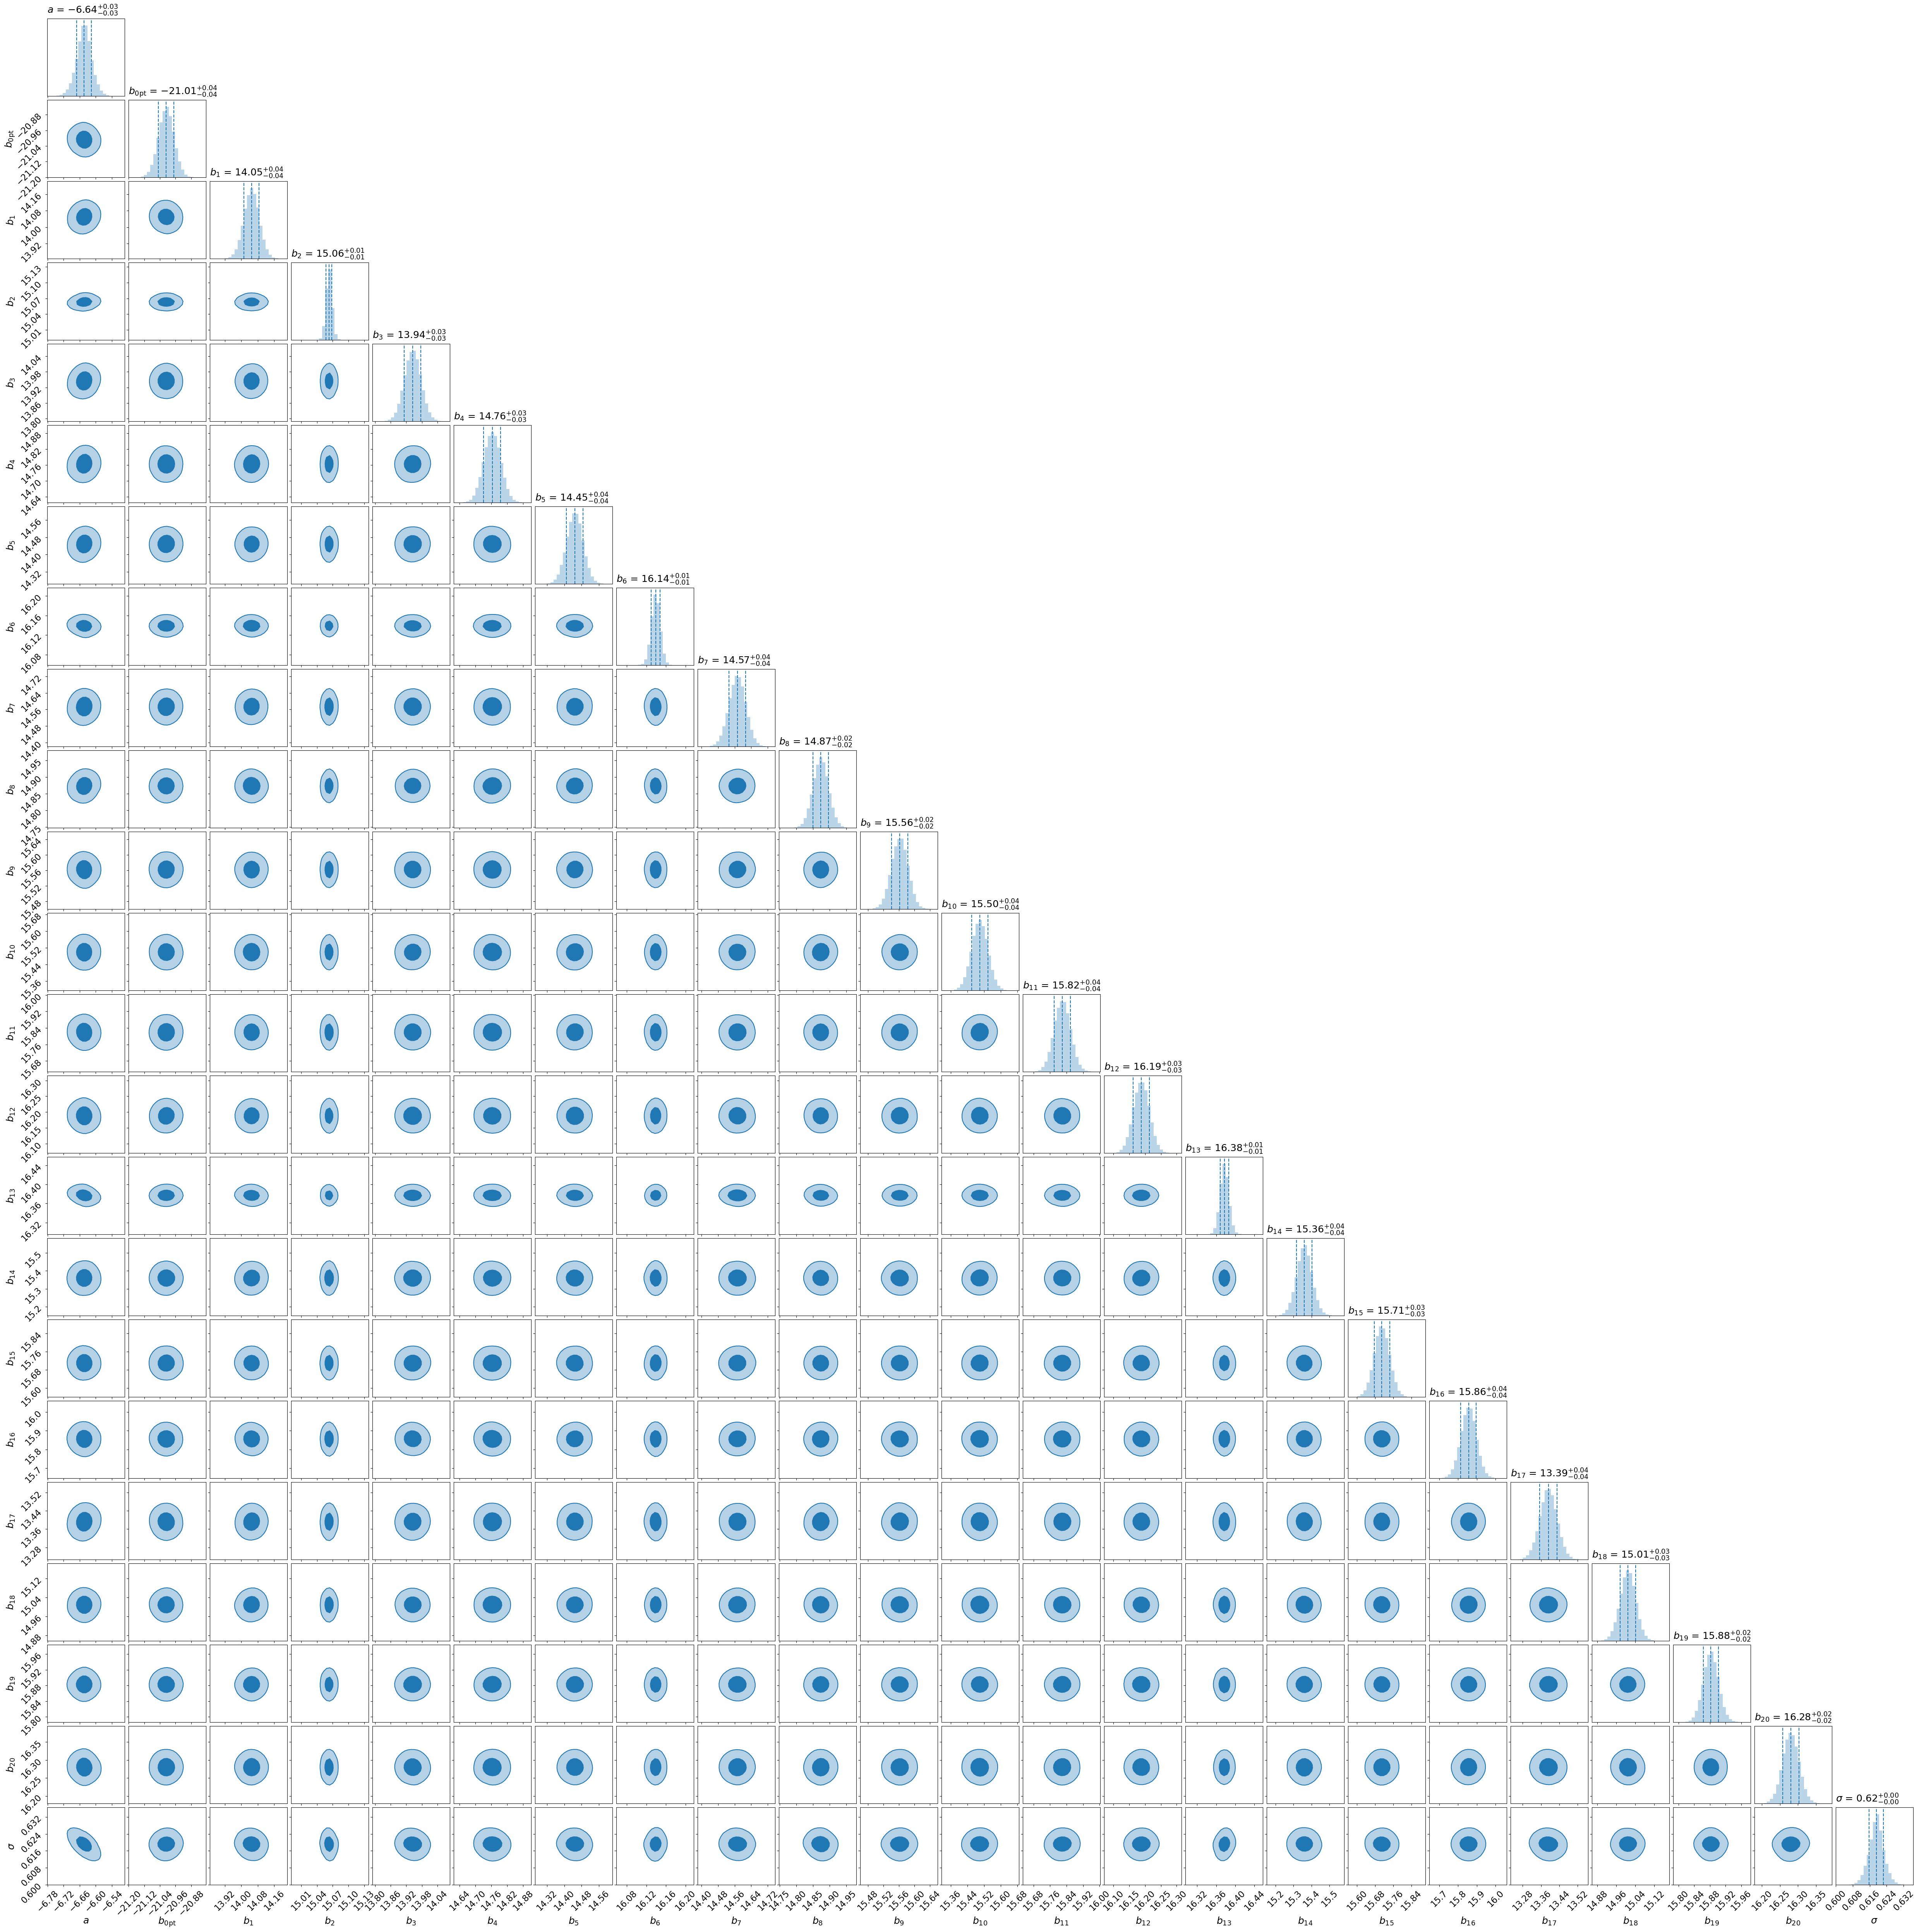

In [49]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
# fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1.png', dpi=150);

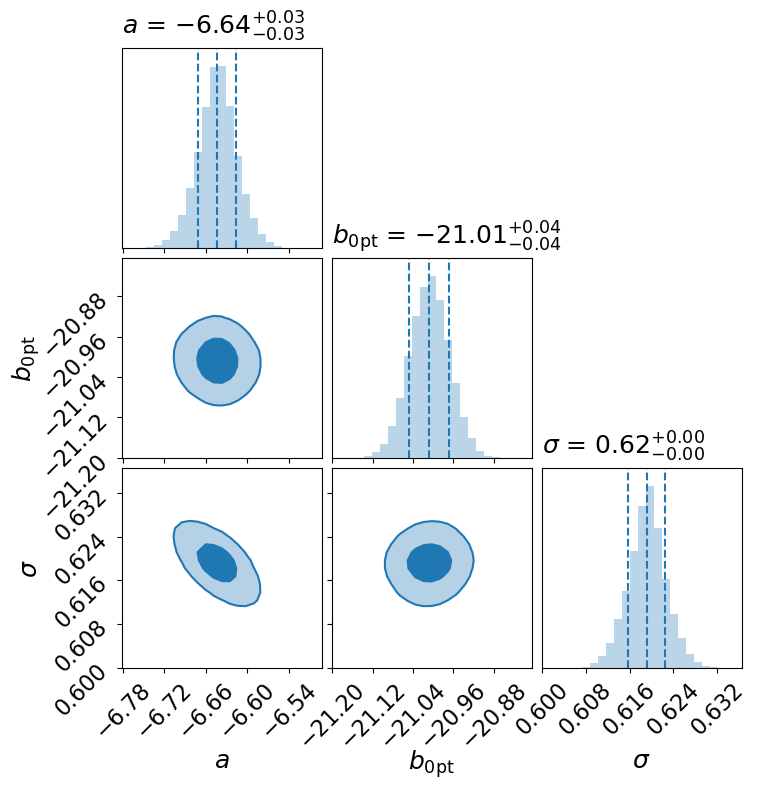

In [50]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$']
labels += [r'$\sigma$']

param_indices = [0, 1, tfr_mcmc_samples.T.shape[1] - 1]


fig = corner(tfr_mcmc_samples.T[:, param_indices], bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
# fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1_full_VI.png', dpi=150);

In [40]:
# # Read in the pickle file with the fit

# # Open the pickle file and load the data
# with open('cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_full_VI.pickle', 'rb') as temp_infile:
#     cov_tfr, tfr_mcmc_samples, logV0 = pickle.load(temp_infile)

# # Now the variables cov_tfr, tfr_mcmc_samples, and logV0 are defined and available to use


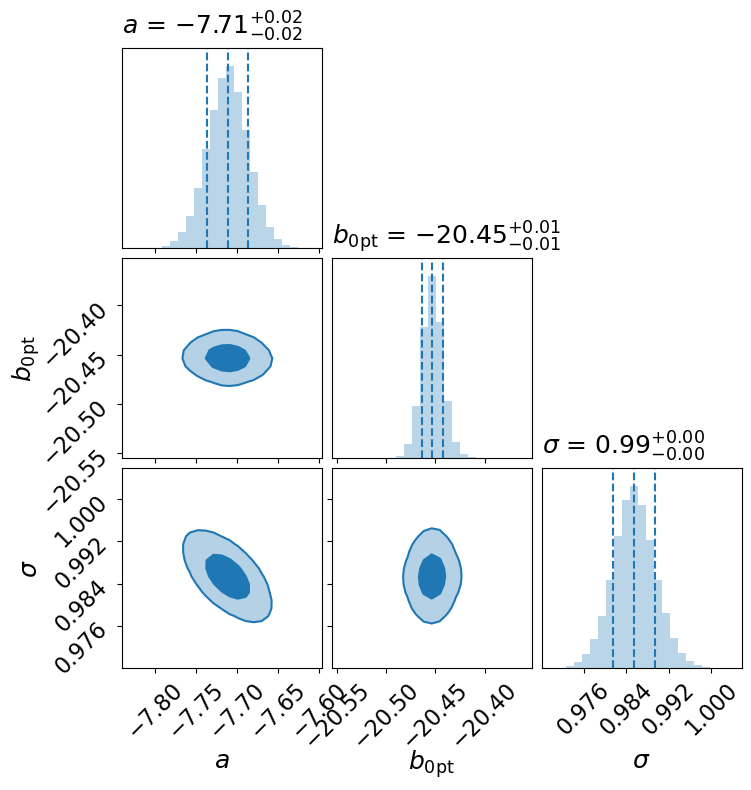

In [41]:
# labels  = ['$a$']
# labels += ['$b_{0\mathrm{pt}}$']
# labels += [r'$\sigma$']

# param_indices = [0, 1, tfr_mcmc_samples.T.shape[1] - 1]


# fig = corner(tfr_mcmc_samples.T[:, param_indices], bins=25, smooth=1,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:blue',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=True,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

# for ax in fig.get_axes():
#     ax.tick_params(axis='both', which='major', labelsize=16)
# # fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1_full_VI.png', dpi=150);

### Plot the HyperFit Results

In [51]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

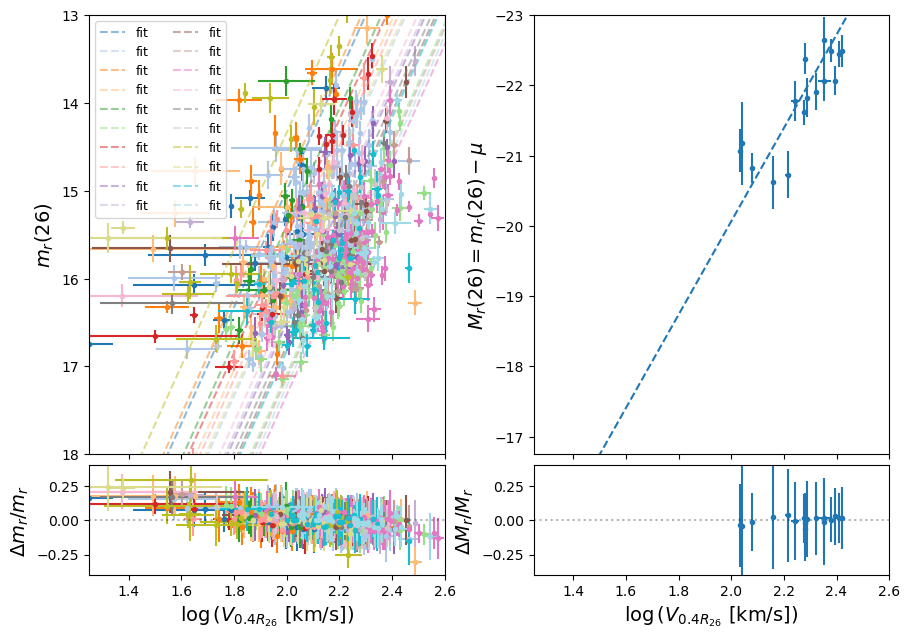

In [52]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', )
                     # label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5, label='fit')

ax.set(xlim=[1.25, 2.75],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r (26)$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--', label='fit')
ax.set(xlim=[1.25, 2.75],
       ylim=[-16.75, -23])
ax.set_ylabel(r'$M_r(26) = m_r(26) - \mu$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('Figures/TF_Y3_cluster_calibration_0pt_binaryML_fit_wightsVmax-1.png', dpi=150)

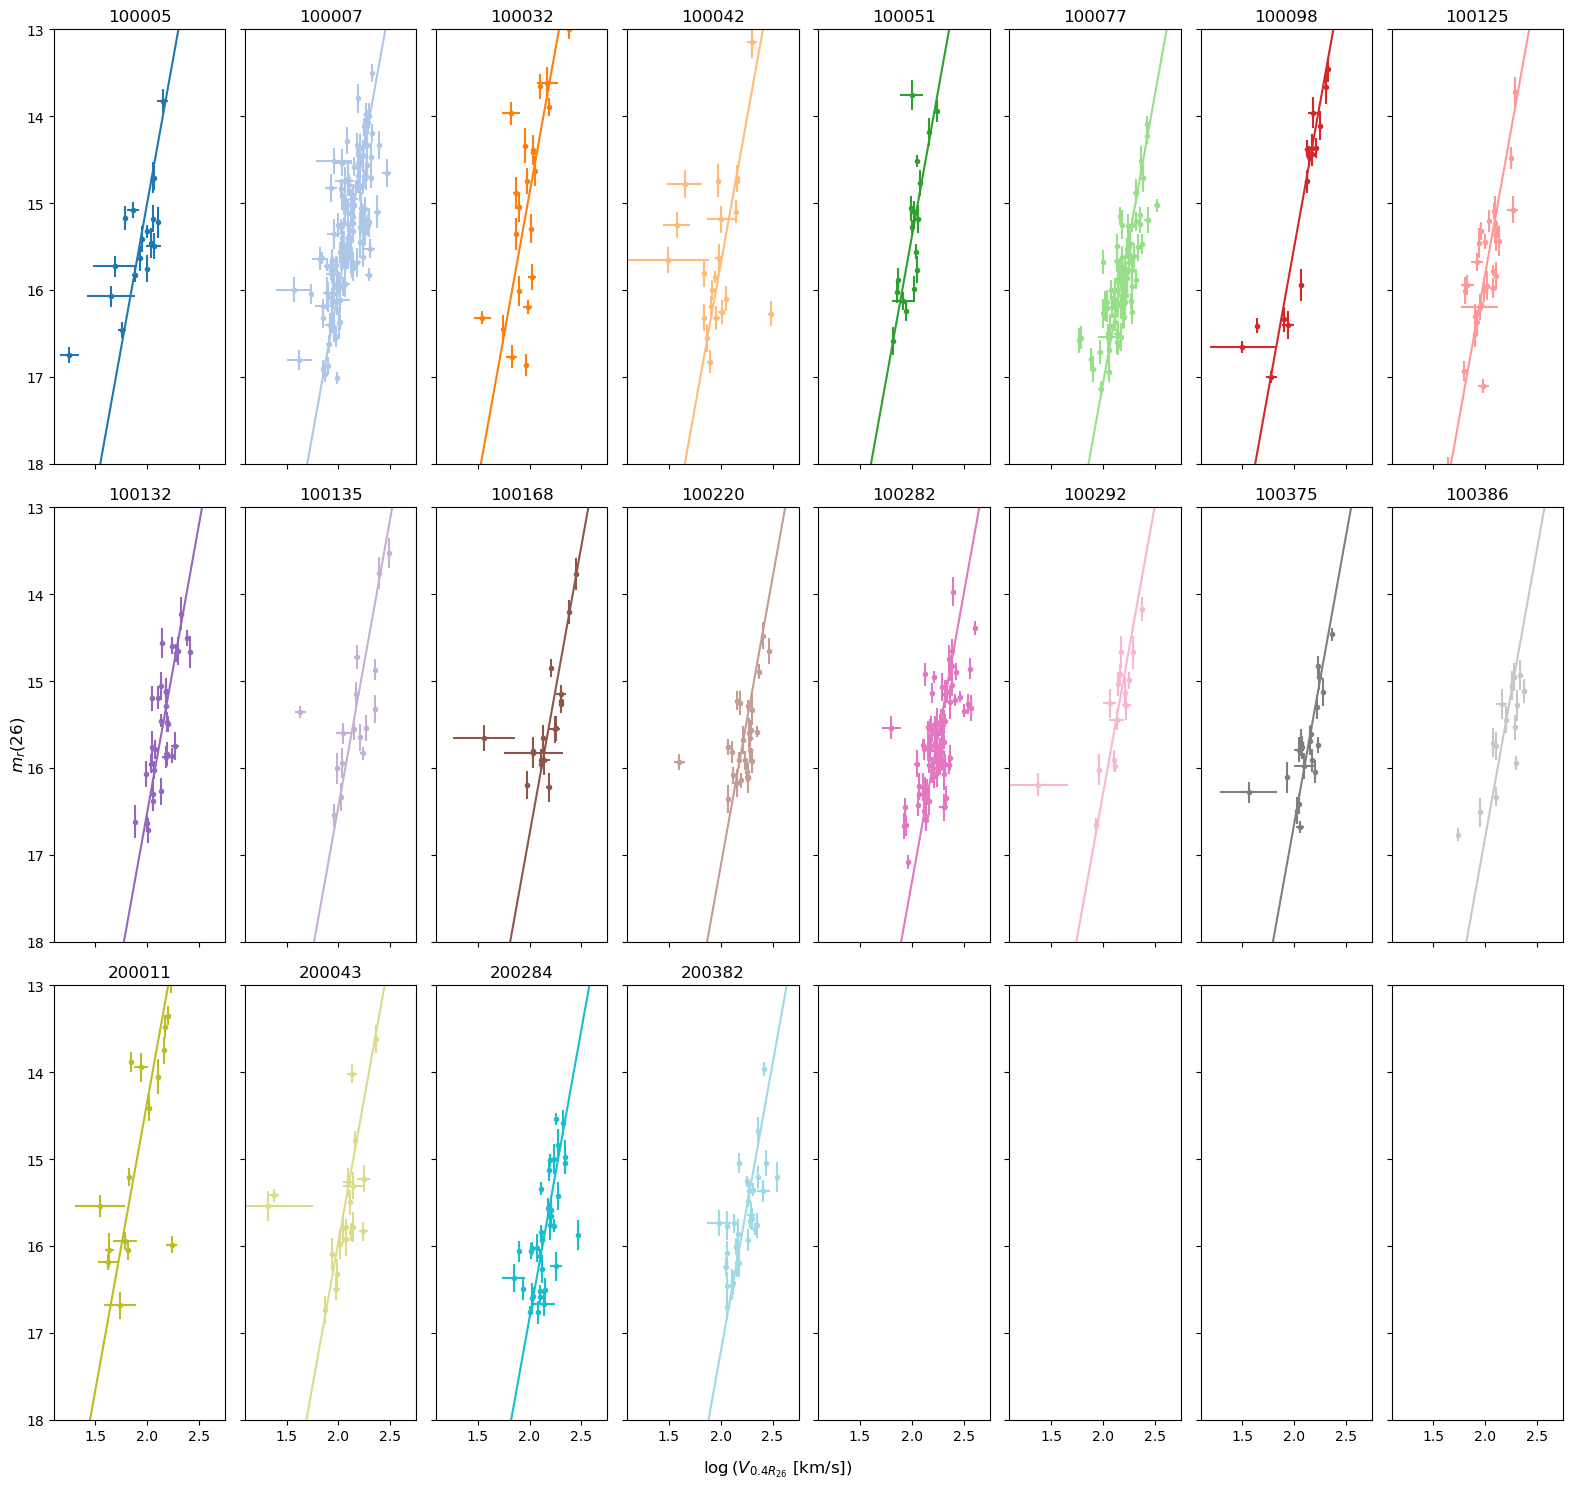

In [53]:
fig, axs = plt.subplots(nrows= int(np.ceil(len(_cluster_ids)/8)), ncols=8, sharex=True, sharey=True, figsize = (16,15), tight_layout=False)

color = iter(plt.get_cmap('tab20').colors)
for i in range(m):
    c = plt.get_cmap('tab20').colors[i % 20]
    
    row = int(i/8)
    col = i%8
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.1, 2.75], ylim=[18, 13], title=f'{_cluster_ids[i]}')
    
fig.supxlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r (26)$');
# plt.savefig('Figures/Y3_Individual_Cluster_Fits_full_sample.png')

## Check for Dwarf Galaxies

In [54]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

34.57682365044518 km/s


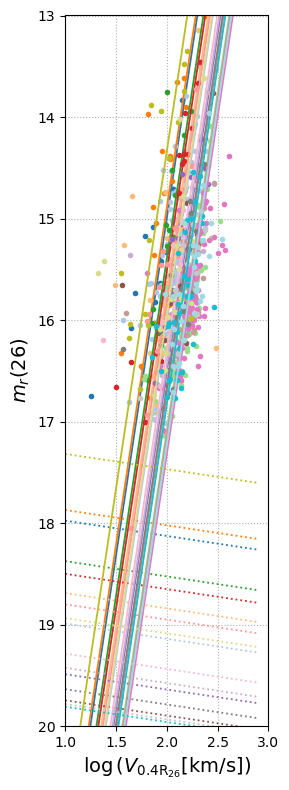

In [55]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1, 3)
plt.ylim(20, 13)

plt.gca().set_aspect('equal');

In [56]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[i])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0


## Redo fit without dwarves (if needed)

### First, let's check the counts within each cluster to see if all of the clusters still statisfy the minimum galaxy count

In [57]:
group, grp_count = np.unique(caltab_bright['CLUSTER_ID'], return_counts = True)
grp, grp_count_original = np.unique(caltab['CLUSTER_ID'], return_counts = True)
smaller_grps = group[grp_count < 15]
print(smaller_grps)
diffs = grp_count_original - grp_count
diffs

CLUSTER_ID
----------


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

The cluster that now has less than 15 galaxies will be dropped from our sample because it is now to small. Let's look at how the cluster that lost 19 galaxies looks now:

<SkyCoord (ICRS): (ra, dec) in deg
    (187.75580155, 12.40596574)>
1575.9999999999986 +/- 610 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (187.75580155, 12.40596574)>
1575.9999999999986 +/- 610 km/s


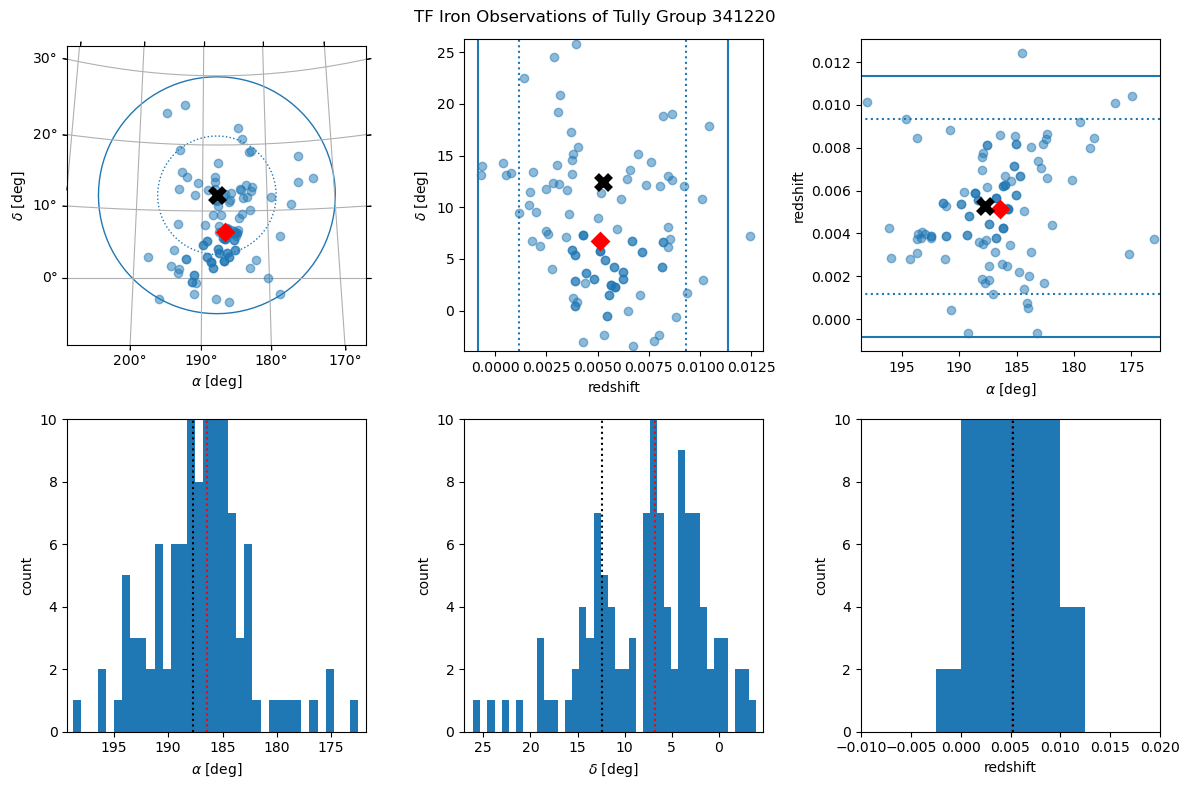

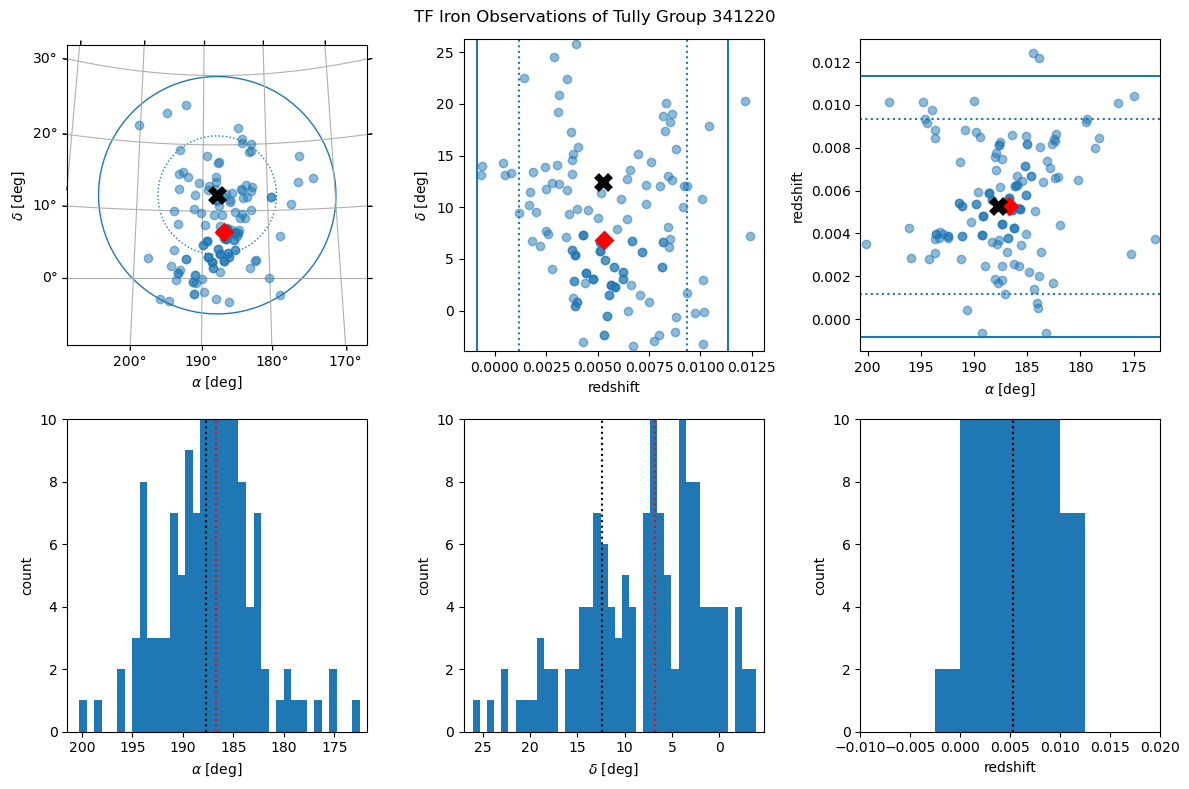

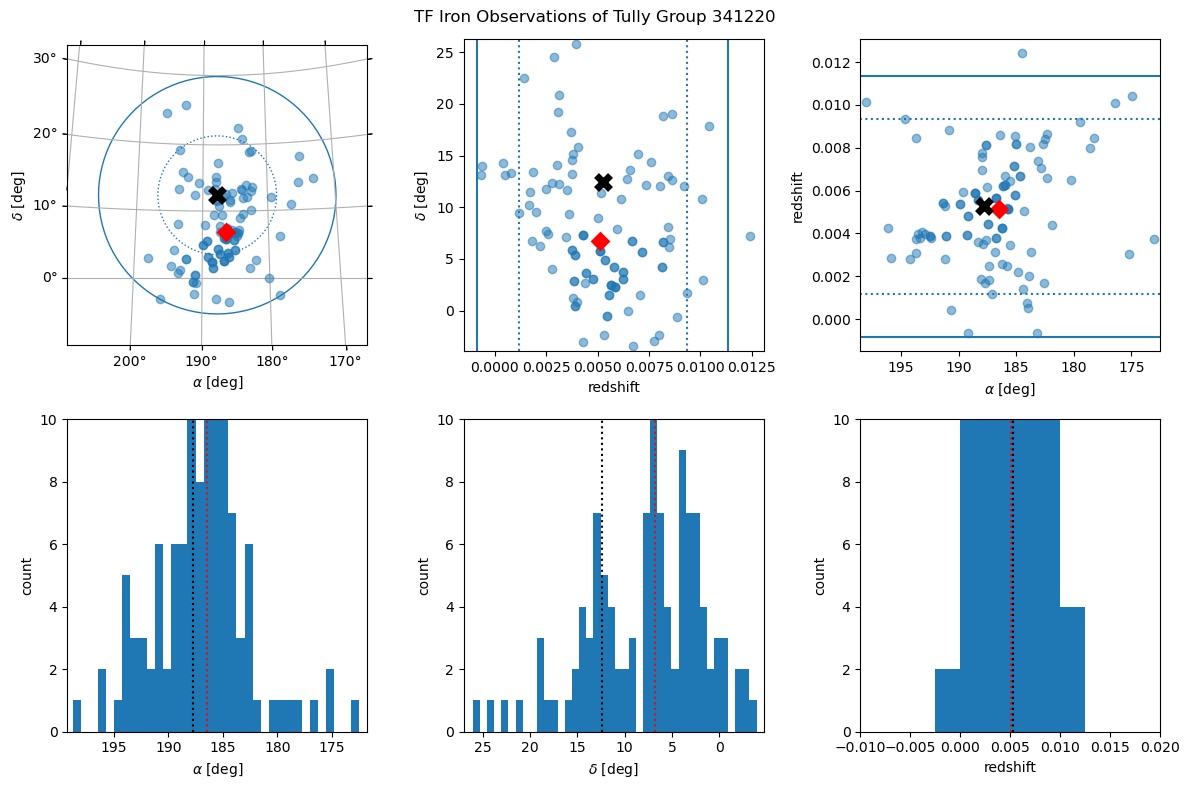

In [60]:
plot_cluster_members(clusters, 341220, caltab, sga_clusters[341220])
plot_cluster_members(clusters, 341220, caltab_bright, sga_clusters[341220])

This cluster still looks well populated, so we will still include it in the sample (just without those 19 dwarves). So, we just need to remove cluster 341789.

In [61]:
caltab_bright = caltab_bright[caltab_bright['CLUSTER_ID'] !=341789]

In [63]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab_bright['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab_bright['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])
weights.append(np.array(1/zeroptab['MAX_VOL_FRAC']))

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab_bright['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab_bright['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab_bright['V_0p4R26_err'][select_cluster] / caltab_bright['V_0p4R26'][select_cluster])
    mag.append(caltab_bright['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab_bright['R_MAG_SB26_ERR_CORR'][select_cluster])
    weights.append(np.array(1/caltab_bright['MAX_VOL_FRAC'][select_cluster]))


bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

logV0 = 2.1045992483698304
     fun: -93798.87631964262
     jac: array([ 0.05675247,  0.02037268,  0.03492459, -0.00873115, -0.07566995,
        0.10768416, -0.09022187,  0.21827871, -0.14551914,  0.05529727,
       -0.02328306,  0.04074536,  0.13096723,  0.16007105,  0.09604263,
       -0.04947651,  0.16589182,  0.35652189,  0.068394  , -0.02619345,
        0.12223608,  0.02037268, -0.0334694 , -0.02764864, -0.15716067,
       -0.07275957, -0.06111804,  0.09167706, -0.02182787,  0.02764864,
       -0.33178364, -0.01309672,  0.09604263,  0.00582077, -0.16152626])
 message: 'Optimization terminated successfully.'
    nfev: 163686
     nit: 309
 success: True
       x: array([ -7.34763186, -20.64799718,  15.04338406,  14.14839821,
        15.30432204,  14.08503457,  14.98481651,  14.91337288,
        15.19974532,  14.43560637,  14.62046853,  15.43025056,
        15.0799088 ,  16.44257498,  15.15024837,  14.80690679,
        15.06621896,  15.05924066,  15.84624942,  15.77152109,
        

100%|██████████| 1000/1000 [03:46<00:00,  4.41it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [97.5989716  93.97778367 98.14593252 89.57168823 89.83819442 87.68915211
 94.90048724 91.78745579 93.12073146 97.94248955 92.97918592 94.53380083
 90.81118137 91.00764901 89.96332676 91.58595552 88.30470042 92.14461804
 93.24641561 88.11450187 93.10988098 90.15454215 94.46602935 91.2291215
 90.87849302 88.72814379 94.36978911 92.15263041 94.88946941 89.14000596
 95.37617295 98.14974703 94.37935757 92.00976254 91.94119795] / 4907.4873513840985


100%|██████████| 1000/1000 [03:40<00:00,  4.53it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [122.99063169 120.37291479 121.58158276 131.15541283 118.17500602
 128.07146193 129.14029487 132.1834361  126.94853509 131.43590976
 129.15408521 133.79037829 124.66479711 121.36719877 129.53842625
 136.50799859 125.6027508  121.86440196 130.56532997 132.98668399
 133.71755564 129.23992143 127.0662681  117.18774468 124.65792796
 133.03814106 131.56875579 124.70400373 130.89310611 134.93882805
 127.28596632 118.99341635 133.21060073 120.93077483 129.54594042] / 6825.399929740395


100%|██████████| 1000/1000 [03:39<00:00,  4.56it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [154.41530644 152.24476312 154.17322074 163.73149658 138.39837869
 155.9091648  160.44730491 156.04070101 147.1911446  160.94606804
 158.46480353 157.35865081 159.79821636 144.74879178 142.70121042
 155.57899426 154.30864095 150.44913326 161.99157232 156.24355832
 160.96270041 149.43092683 150.98677821 147.46909294 165.77283924
 156.40067218 157.49453867 155.62570376 152.08630876 158.44727229
 149.5495098  151.8059133  160.92918542 155.00015536 143.26431909] / 8288.641961901036


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [174.09203547 166.52175469 165.27823986 191.93607801 150.85941783
 171.06470192 175.87612979 170.42387892 167.59535468 177.81255114
 166.42322101 153.9286241  176.53620056 158.59025659 181.78640195
 179.96103235 174.5621378  163.37614951 169.37851845 177.46552415
 174.91566649 164.51207688 172.35756664 163.50258038 176.38362114
 187.14754612 172.57369594 169.93810264 178.51870869 173.8563414
 165.07646062 166.37402282 169.37483371 174.12145859 173.32341511] / 9596.803900625428


100%|██████████| 1000/1000 [03:40<00:00,  4.53it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [189.91221719 203.18315316 183.23873531 190.90800286 167.04377803
 203.83728957 191.70080132 197.80621892 206.17334246 185.30476112
 196.49076852 186.93507656 204.23496518 190.89935395 202.02622679
 201.56102934 204.47460441 195.58996807 192.70189417 204.70455371
 197.58820863 188.11632596 206.90567311 184.78839987 213.58139984
 208.13452499 196.29472355 186.02773277 198.08038695 190.87478304
 193.41804552 186.84930631 204.15974463 195.58479923 185.0148641 ] / 10679.06999213967


100%|██████████| 1000/1000 [03:43<00:00,  4.47it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [203.71166179 205.48352818 188.79430484 201.29198811 192.45461336
 213.57129298 205.90250617 204.47624965 218.99120877 210.48108069
 209.26677822 200.65719874 211.07974485 189.93264642 210.31192156
 204.06016781 209.59394994 213.69921833 194.03899168 206.89435495
 197.99523929 203.53204828 217.05331244 189.51227219 221.26578328
 204.90611313 194.24672534 211.97244597 200.35605732 218.92512148
 203.18027798 210.89827585 207.31195486 199.18719068 190.30161986] / 11063.289163912572


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [210.19735464 219.04428476 221.57375294 221.97725581 201.77042086
 234.6275281  233.68691509 216.44790596 239.78245391 230.94149592
 218.97613897 231.06473116 226.45787731 203.74248021 227.67221163
 233.61984682 240.55255256 237.87805442 219.71638328 229.18902315
 240.4749622  217.78857604 220.79064606 227.22997363 231.27935841
 223.86903823 212.10209514 227.90191681 219.12940324 230.19577359
 225.18124244 234.74979758 240.02342764 226.91760567 209.34833927] / 12027.627627851785


100%|██████████| 1000/1000 [03:42<00:00,  4.50it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [231.61107188 222.68809835 230.5906107  216.35341139 203.87285687
 241.51174706 236.86938947 217.31218098 242.85317489 242.55090326
 239.06023911 233.69313316 228.12999558 214.10548339 225.38739033
 239.74656375 242.80705482 238.17510578 233.5016949  232.90687899
 242.18180407 236.64699966 223.17909618 254.54793273 230.17589756
 223.56116189 218.45538396 242.94138811 228.891049   234.19683215
 228.96388018 226.43035567 247.81490588 228.76003819 226.1197005 ] / 12727.39663633496


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [251.31247411 230.4771672  234.24271144 240.25659316 217.75044253
 255.02933238 233.66809641 237.22194785 260.49109719 253.18107474
 246.53674541 251.6562765  239.86059027 226.30469938 250.71954644
 255.26440829 257.00089432 259.27014915 250.37991459 238.89863236
 227.67332735 241.40432618 249.79603017 262.46513949 256.3960765
 256.18304074 224.38972536 250.22135875 242.30736522 247.29991047
 237.50844131 237.4124756  255.50543604 238.92165407 249.86024512] / 13123.256974647382


100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [260.17613587 239.61419568 240.56843713 247.08020144 224.48760362
 262.86687036 237.44763176 243.45835526 268.67167707 260.18356231
 262.9865139  233.78926498 242.13555169 231.56298981 246.2318855
 242.97958365 247.91132674 256.0981826  254.51134438 248.04316562
 232.98331343 251.1287272  254.13228895 252.33123257 260.10713933
 260.46530589 234.12590577 252.56503354 235.34943101 256.71172598
 260.2957492  239.93181917 253.67647691 238.39729435 265.39708379] / 13433.583853728376


100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [283.21690933 249.0683678  247.25385452 264.13312191 242.86424962
 264.52168127 254.97992729 262.89686465 279.32369398 269.33989172
 272.18014054 256.3766795  254.67950203 247.64205395 281.18859148
 248.24019252 278.93359766 271.54286694 265.36097939 265.31732458
 257.71451478 258.6645707  261.86287463 251.58338558 274.97140574
 278.79294999 245.74318366 265.34382609 253.68751664 259.35477826
 263.2936025  258.30616542 268.1246646  250.11235209 278.97253428] / 14160.845466323777


100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [281.18095625 252.53478867 246.24568471 278.78267299 234.66097273
 264.94805862 268.68941701 279.03889422 277.28425474 258.11378843
 282.13655913 256.8853952  273.31158054 244.82369238 274.36418925
 265.27416711 283.86529245 265.24105211 255.71028094 267.02280109
 258.66567851 270.52106026 268.72311062 251.406698   279.13968712
 277.77009349 255.96375987 262.71398156 265.79186637 266.71329379
 271.32973043 254.90983034 255.35230769 251.29452178 278.01551206] / 14193.264622527204


100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [294.45836902 267.80388317 247.92322862 280.62503447 248.05324752
 273.91928694 290.11757166 291.19004333 296.29085034 277.3242345
 292.0364418  260.57186689 299.12120097 260.31841485 285.99090307
 272.55889293 292.1611865  263.5643208  270.88055472 278.55749538
 267.41067945 279.71015828 284.93335613 252.09584084 282.21978202
 280.27511328 274.36271754 270.07326903 276.06188403 276.7677427
 286.1734321  257.37128412 264.20313156 258.19431576 292.94429045] / 14956.060048335596


100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [298.42323037 273.39477202 254.36225752 287.03610225 245.82172558
 278.63849446 286.52289863 294.48025971 306.17798516 282.89004831
 293.60943853 258.8956827  299.70334145 262.56978355 283.72561067
 275.2255548  291.4044938  261.08888448 267.54848444 288.5509875
 272.16449485 287.43302383 290.27992504 263.38883812 282.16437161
 274.17874068 289.45466464 278.89217164 276.7489986  278.29708954
 282.70220863 260.27564878 270.43591734 265.54405748 289.11098521] / 15308.899257870999


100%|██████████| 1000/1000 [03:44<00:00,  4.46it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [297.10812576 293.25843856 262.33973617 292.29285953 259.60561646
 290.64305373 295.16203412 296.4642049  300.25271055 285.37119652
 311.57067809 269.33444734 302.7202995  272.09757613 294.52766877
 280.58168852 299.38480536 258.19949385 279.6255758  289.08440889
 287.69606896 306.34279498 301.18089838 271.30412281 280.91410815
 285.46022799 305.37297799 289.34239258 289.60442505 288.19549432
 288.7036651  268.24166441 279.74127633 273.73570378 299.73143673] / 15578.53390457082


100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [301.95148353 281.74365035 269.6543877  297.57419774 261.6684077
 282.48772462 300.69359281 287.11238495 299.39957794 282.78412765
 301.51077167 273.30996477 301.81950013 269.4535137  293.29537545
 293.66796197 303.39798832 259.91993551 279.58488764 291.92633616
 293.96188026 308.78318892 299.5282057  274.83925735 285.28960513
 293.68789923 306.99964989 291.85448931 288.21844691 297.34261382
 291.33401199 273.63440632 276.91816656 270.57145935 303.12858898] / 15439.159446169466


100%|██████████| 1000/1000 [03:42<00:00,  4.50it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [311.8555363  291.74743766 271.63525182 300.17470577 267.91433965
 291.76877907 310.71976961 288.20169581 300.48500135 296.53108621
 311.72066794 281.53239399 302.43373583 289.36714008 298.109988
 316.76081403 328.93188143 289.39152799 290.80809911 301.831268
 297.09675799 323.34373835 303.43155651 284.19646223 291.59068382
 296.48468389 323.73923354 306.64456229 292.58630929 311.77580007
 297.3827936  286.55323151 281.78305739 280.34439245 315.17514171] / 16446.594071624197


100%|██████████| 1000/1000 [03:38<00:00,  4.57it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [319.29627553 287.81911994 273.23098172 294.69800647 266.33288981
 303.09637166 308.21697584 302.28429206 296.19940216 308.55554204
 313.38176361 284.05828732 303.14420357 301.54051341 303.85447296
 310.55513734 332.51367169 294.14699208 290.19036711 314.7639415
 299.40258509 327.36714757 302.02515504 286.87229186 296.1112013
 295.94250465 322.9649689  308.64178566 293.53459266 311.48226484
 300.20005716 291.2208291  289.3931613  279.91818835 317.1158464 ] / 16625.683584738264


In [64]:
temp_outfile = open('cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_full_VI_lessdwarves_v2_primarySN.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

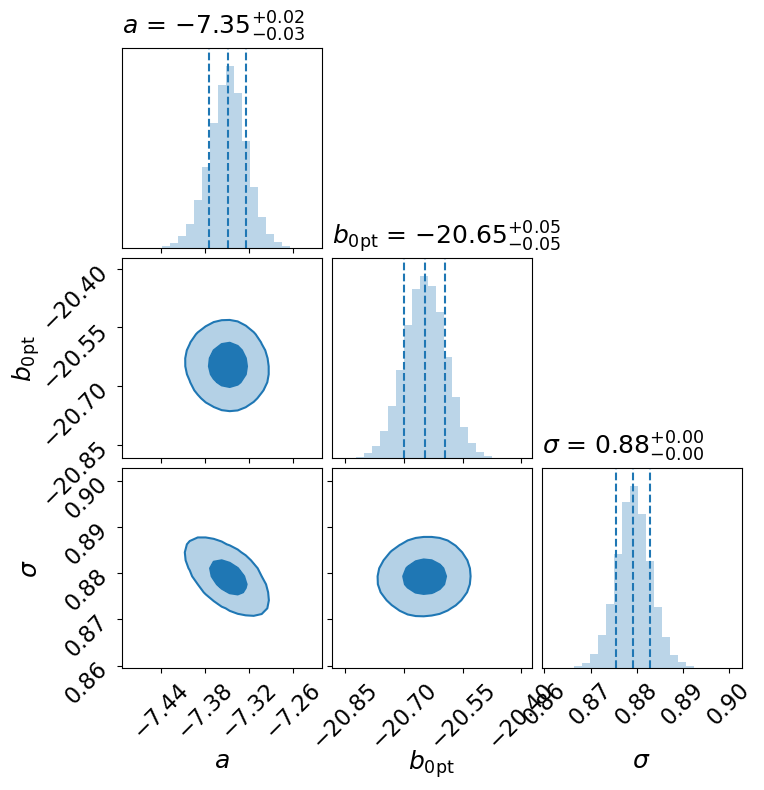

In [65]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$']
labels += [r'$\sigma$']

param_indices = [0, 1, tfr_mcmc_samples.T.shape[1] - 1]


fig = corner(tfr_mcmc_samples.T[:, param_indices], bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
# fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1_full_VI_lessdwarves.png', dpi=150);

45.49365098156825 km/s


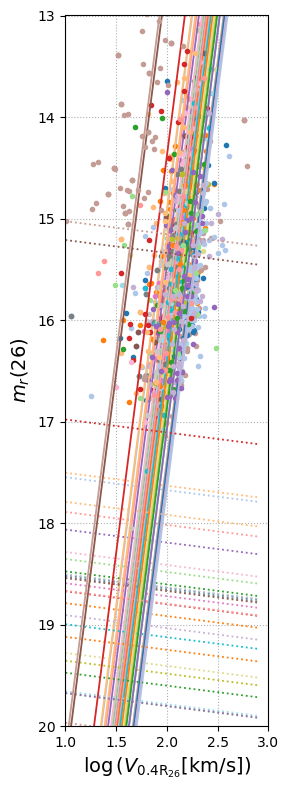

In [66]:
## Now check the dwarf counts

logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')


plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1, 3)
plt.ylim(20, 13)

plt.gca().set_aspect('equal');

In [67]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[i])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright_2 = caltab[~dwarfs]

print(np.sum(dwarfs))

19


In [61]:
# #### Read in the results from with the overlapping fit so we can do the corner plots together

# # Read in the pickle file with the fit

# # Open the pickle file and load the data
with open('cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_williams_Y3.pickle', 'rb') as temp_infile: #Williams fit
    cov_tfr2, tfr_mcmc_samples2, logV02 = pickle.load(temp_infile)

# with open('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_tempel.pickle', 'rb') as temp_infile: #Tempel Fit
#     cov_tfr3, tfr_mcmc_samples3, logV03 = pickle.load(temp_infile)

# with open('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_nooverlap_VI.pickle', 'rb') as temp_infile: #Y3 no overlap
#     cov_tfr4, tfr_mcmc_samples4, logV04 = pickle.load(temp_infile)

# with open('/global/homes/s/sgmoore1/DESI_SGA/TF/Y1/cov_ab_iron_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_Anthony_weightsVmax-1_dVsys_KAD-20250523.pickle', 'rb') as temp_infile: #Y1 full fit
#     cov_tfr5, tfr_mcmc_samples5, logV05 = pickle.load(temp_infile)

# with open('cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_full_VI_lessdwarves_v2.pickle', 'rb') as temp_infile: #all SN Y3 full fit
#     cov_tfr6, tfr_mcmc_samples6, logV06 = pickle.load(temp_infile)

with open('cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_williams_Y3_primarySN.pickle', 'rb') as temp_infile: #only primary SN williams fit
    cov_tfr7, tfr_mcmc_samples7, logV07 = pickle.load(temp_infile)



# # Now the variables cov_tfr, tfr_mcmc_samples, and logV0 are defined and available to use


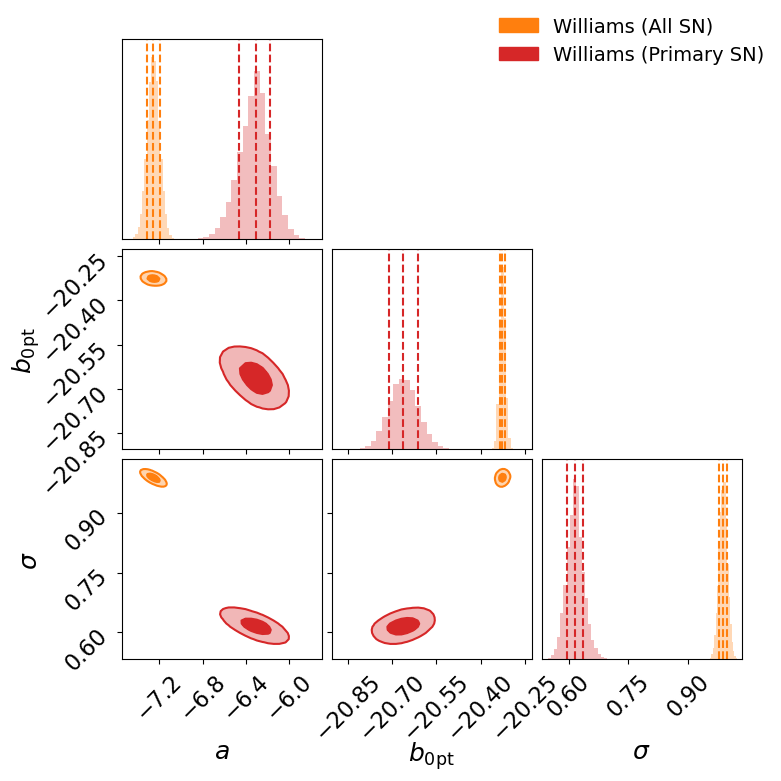

In [65]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Labels with just parameter names
labels = [r'$a$', r'$b_{0\mathrm{pt}}$', r'$\sigma$']

# param_indices = [0, 1, tfr_mcmc_samples.T.shape[1] - 1]
param_indices2 = [0, 1, tfr_mcmc_samples2.T.shape[1] - 1]
# param_indices3 = [0, 1, tfr_mcmc_samples3.T.shape[1] - 1]
# param_indices4 = [0, 1, tfr_mcmc_samples4.T.shape[1] - 1]
# param_indices5 = [0, 1, tfr_mcmc_samples5.T.shape[1] - 1]
# param_indices6 = [0, 1, tfr_mcmc_samples6.T.shape[1] - 1]
param_indices7 = [0, 1, tfr_mcmc_samples7.T.shape[1] - 1]

# fig = corner(tfr_mcmc_samples.T[:, param_indices], bins=25, smooth=1,
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:blue',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=False)  # disable auto stats in titles

fig = corner(tfr_mcmc_samples2.T[:, param_indices2], bins=25, smooth=1,
            # fig=fig,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:orange',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=False,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

# corner(tfr_mcmc_samples3.T[:, param_indices3], bins=25, smooth=1,
#             fig=fig,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:green',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=False,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});
# corner(tfr_mcmc_samples4.T[:, param_indices4], bins=25, smooth=1,
#             fig=fig,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:red',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=False,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});
# corner(tfr_mcmc_samples5.T[:, param_indices5], bins=25, smooth=1,
#             fig=fig,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='black',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=False,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});
# corner(tfr_mcmc_samples6.T[:, param_indices6], bins=25, smooth=1,
#             fig=fig,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:red',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=False,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});
corner(tfr_mcmc_samples7.T[:, param_indices7], bins=25, smooth=1,
            fig=fig,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:red',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=False,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

# Format ticks
for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# Create custom legend handles
legend_handles = [
    # Patch(color='tab:blue', label='Y3 Tully No Overlap (Primary SN)'),
    Patch(color='tab:orange', label='Williams (All SN)'),
    # Patch(color='tab:green', label='Tempel'),
    Patch(color='tab:red', label='Williams (Primary SN)'),
    # Patch(color='black', label='Y1 Tully'),
]

# Add legend in top right of the figure
fig.legend(handles=legend_handles, loc='upper right', fontsize=14, frameon=False)

# Optional save
# fig.savefig('my_corner_plot.png', dpi=150)


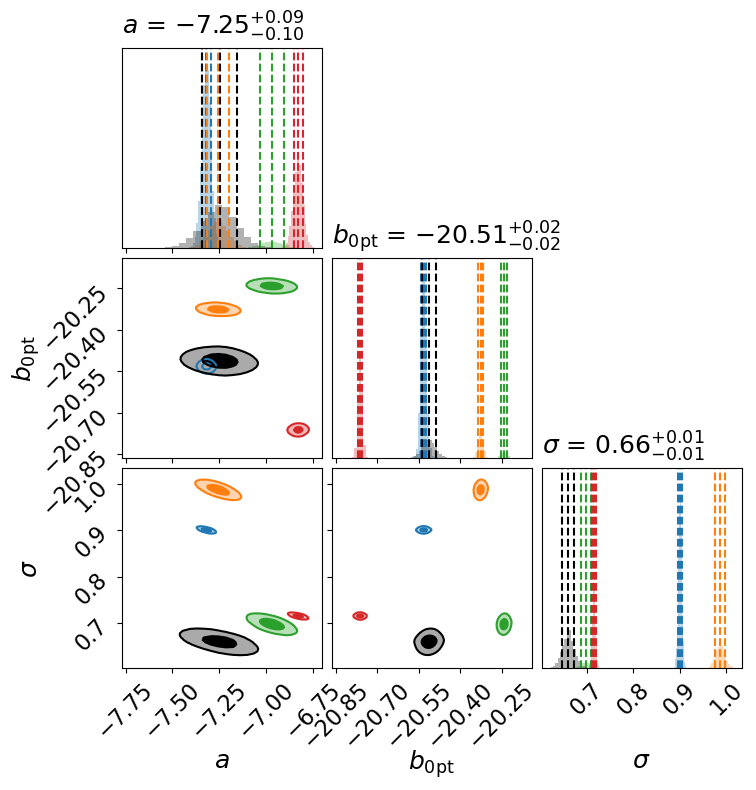

In [89]:
# labels  = ['$a$']
# labels += ['$b_{0\mathrm{pt}}$']
# labels += [r'$\sigma$']

# param_indices = [0, 1, tfr_mcmc_samples.T.shape[1] - 1]
# param_indices2 = [0, 1, tfr_mcmc_samples2.T.shape[1] - 1]
# param_indices3 = [0, 1, tfr_mcmc_samples3.T.shape[1] - 1]
# param_indices4 = [0, 1, tfr_mcmc_samples4.T.shape[1] - 1]
# param_indices5 = [0, 1, tfr_mcmc_samples5.T.shape[1] - 1]

# fig = corner(tfr_mcmc_samples.T[:, param_indices], bins=25, smooth=1,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:blue',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=True,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

# corner(tfr_mcmc_samples2.T[:, param_indices2], bins=25, smooth=1,
#             fig=fig,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:orange',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=True,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

# corner(tfr_mcmc_samples3.T[:, param_indices3], bins=25, smooth=1,
#             fig=fig,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:green',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=True,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});
# corner(tfr_mcmc_samples4.T[:, param_indices4], bins=25, smooth=1,
#             fig=fig,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:red',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=True,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});
# corner(tfr_mcmc_samples5.T[:, param_indices5], bins=25, smooth=1,
#             fig=fig,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='black',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=True,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});



# for ax in fig.get_axes():
#     ax.tick_params(axis='both', which='major', labelsize=16)
# # fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1.png', dpi=150);